# Predecting Dangerous Junction Using ML
`This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not junction is dangerous for a specific person.`

**This notebook is organized into three main parts:**
> A.) `"Predicting Urban Intersection Risk with Machine Learning":`
In this section, I walk through the six essential steps I followed to develop the model, from understanding and preparing the data to evaluating the results. You can explore each step in detail or skip ahead to Section B for a look at the model’s performance .

> B.) `"Insights and Visual Analysis":`
Here, you’ll find some additional insights on model performance and ways to interpret and apply the model's results.

> C.) `"Saving and Reusing the Model":`
The final part of the notebook covers how the trained model can be saved, reloaded, and reused—either for integration into an app or for further experimentation.

# A - walk through the six essential steps - Predicting Urban Intersection Risk
`This project is organized into a comprehensive data science workflow consisting of six steps`
<img src="images/workflow.png" alt="tools Image">




## A.1 – Problem Definition:

Predict how dangerous a specific urban intersection is, based on accident history and contextual factors (time, weather, driver demographics, etc.).
Goal: Produce a risk score or category that can help drivers anticipate danger before arriving at an intersection.

We plan to treat this as either:
- A **classification problem** (e.g., predicting risk level: low, medium, high)
- Or a **regression task** (e.g., predicting a continuous risk score)

   **Defining the Risk Score:**

In this project, we aimed to assess the **risk level of urban intersections** based on historical accident data.  
Since no ready-made "risk label" exists in the raw data, we designed a custom metric called **Base Risk Score**, calculated using:

- The **number of accidents** at each intersection.
- The **severity** of those accidents (e.g., fatalities, severe injuries, light injuries).
- Optional: Additional contextual information such as time of day, day of the week, or location.

This approach is inspired by methods used in **real-world traffic safety analysis**, where both frequency and severity are considered essential when evaluating danger levels.

- We didn't invent data — we summarized real and measurable outcomes into a **composite risk score**.
- The score allows us to compare intersections in a consistent way.
- It can be used as a **regression target** or categorized into risk levels for **classification** models.
- This makes the project useful not only as a data science exercise, but also as a **practical tool for cities, navigation systems, and safety planning**.

> For a more detailed explanation of how the score is calculated and the reasoning behind the formula,  
> please refer to **Section A4.1** of the report, where we elaborate on the logic and justification of the Base Risk Score construction.




## A.2 - Data 
The data used in this project was collected from the Israeli National Road Safety Authority (רלב"ד) for the year 2023. It consists of two official datasets:

Accident Data – Includes information about road accidents, such as accident location (intersections, road coordinates), time and date, severity, weather conditions, lighting, road type, and more.

Involved Persons Data – Contains demographic and behavioral details about each person involved in the accident, including role (driver/passenger/pedestrian), gender, age group, vehicle type, license issuance year, and injury details.

These datasets are linked using a shared accident ID (pk_teuna_fikt), which allows for merging and cross-referencing between accident-level and individual-level data.

### Load Data

In [1]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization library

# We want our plots to appear inside the notebook
%matplotlib inline 

In [2]:
pip install seaborn


In [3]:
import pandas as pd
df_dataAcc = pd.read_csv("data/dataAcc.csv") 
df_dataAcc

,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,REHOV1,REHOV2,BAYIT,ZOMET_IRONI,KVISH1,...,MEKOM_HAZIYA,KIVUN_HAZIYA,MAHOZ,NAFA,EZOR_TIVI,MAAMAD_MINIZIPALI,ZURAT_ISHUV,STATUS_IGUN,X,Y
0,2023000009,1,1,2,8600,719.0,NaN,104.0,NaN,NaN,...,0,9,5,51,512,0.0,14,1,183206.0,666306.0
1,2023000011,1,1,2,9700,NaN,NaN,9999.0,NaN,NaN,...,0,9,4,42,421,0.0,15,2,190185.0,673239.0
2,2023000013,1,1,2,8300,120.0,NaN,9999.0,NaN,NaN,...,0,9,4,44,442,0.0,13,3,179498.0,653490.0
3,2023000014,1,1,3,0,NaN,NaN,NaN,NaN,4.0,...,0,9,3,31,311,99.0,99,1,209195.0,751807.0
4,2023000021,1,1,2,3000,4121.0,NaN,9999.0,NaN,NaN,...,0,9,1,11,111,0.0,12,2,223381.0,633927.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,2023099950,1,1,2,3000,4763.0,NaN,2.0,NaN,NaN,...,0,9,1,11,111,0.0,12,3,221256.0,637964.0
8828,2023099951,1,1,2,5000,116.0,NaN,93.0,NaN,NaN,...,0,9,5,51,511,0.0,13,1,181474.0,669710.0
8829,2023099957,1,1,1,6600,751.0,736.0,NaN,11100356.0,NaN,...,3,9,5,51,513,0.0,14,1,178893.0,657953.0
8830,2023099981,1,1,4,0,NaN,NaN,NaN,NaN,4.0,...,0,9,5,51,512,99.0,99,1,185389.0,664592.0


**Filter to Urban Intersections**

In [4]:
# Count missing values in ZOMET_IRONI
missing_count = df_dataAcc['ZOMET_IRONI'].isna().sum()
total_rows = len(df_dataAcc)

print(f"Missing values in ZOMET_IRONI: {missing_count}/{total_rows}")


Missing values in ZOMET_IRONI: 6148/8832


In [5]:
# Filter rows where ZOMET_IRONI is not NaN
df_urban_intersections = df_dataAcc[df_dataAcc['ZOMET_IRONI'].notna()]
df_urban_intersections 


,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,REHOV1,REHOV2,BAYIT,ZOMET_IRONI,KVISH1,...,MEKOM_HAZIYA,KIVUN_HAZIYA,MAHOZ,NAFA,EZOR_TIVI,MAAMAD_MINIZIPALI,ZURAT_ISHUV,STATUS_IGUN,X,Y
7,2023000040,1,1,1,6200,312.0,221.0,NaN,7810031.0,NaN,...,0,9,5,51,513,0.0,14,1,175748.0,657646.0
11,2023000059,1,1,1,7600,505.0,205.0,NaN,7620005.0,NaN,...,3,1,2,24,246,0.0,15,1,207762.0,759167.0
12,2023000073,1,1,1,6100,825.0,856.0,NaN,9520041.0,NaN,...,3,9,5,51,512,0.0,13,1,185084.0,665378.0
14,2023000076,1,1,1,70,715.0,704.0,NaN,8730052.0,NaN,...,0,9,6,61,613,0.0,13,1,166862.0,632180.0
19,2023000118,1,1,1,2600,372.0,384.0,NaN,8080004.0,NaN,...,0,9,6,62,625,0.0,15,1,193783.0,385959.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8819,2023099870,1,1,1,9500,207.0,124.0,NaN,7510005.0,NaN,...,0,9,3,31,311,0.0,16,1,208832.0,749078.0
8820,2023099879,1,1,1,5000,461.0,711.0,NaN,7700331.0,NaN,...,4,1,5,51,511,0.0,13,1,178331.0,665574.0
8822,2023099887,1,1,1,3000,1121.0,1093.0,NaN,92870888.0,NaN,...,0,9,1,11,111,0.0,12,1,217745.0,631262.0
8824,2023099916,1,1,1,3000,1863.0,1839.0,NaN,26330536.0,NaN,...,0,9,1,11,111,0.0,12,1,220351.0,628200.0


**Read the Inv Data**

In [6]:
df_dataInv = pd.read_csv("data/dataInv.csv") 
df_dataInv

,pk_teuna_fikt,MISPAR_REHEV_fikt,ZEHUT_fikt,SHNAT_TEUNA,HODESH_TEUNA,SUG_MEORAV,SHNAT_HOZAA,KVUZA_GIL,MIN,SUG_REHEV_NASA_LMS,...,PEULAT_NIFGA_LMS,KVUTZAT_OHLUSIYA_LMS,MAHOZ_MEGURIM,NAFA_MEGURIM,EZOR_TIVI_MEGURIM,MAAMAD_MINIZIPALI_MEGURIM,ZURAT_ISHUV_MEGURIM,SUG_TIK,ShimushBeAvizareyBetihut_LMS,PtiraMeuheret_LMS
0,2023000009,1,2,2023,4,2,2010,7,1,21.0,...,1,1,5.0,51,513.0,0.0,14.0,1,NaN,NaN
1,2023000009,2,1,2023,4,1,0,99,0,8.0,...,8,1,NaN,99,NaN,NaN,NaN,1,NaN,NaN
2,2023000011,0,2,2023,5,3,0,17,1,NaN,...,9,1,4.0,42,421.0,0.0,15.0,1,1.0,NaN
3,2023000011,1,1,2023,5,1,0,99,0,17.0,...,8,1,NaN,99,NaN,NaN,NaN,1,NaN,NaN
4,2023000013,1,2,2023,7,1,1985,13,1,11.0,...,8,1,4.0,43,432.0,0.0,15.0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22785,2023099957,0,2,2023,4,3,0,9,2,NaN,...,9,3,5.0,51,513.0,0.0,14.0,1,NaN,NaN
22786,2023099957,1,1,2023,4,1,1974,15,1,12.0,...,8,1,5.0,51,513.0,0.0,14.0,1,NaN,NaN
22787,2023099981,1,1,2023,5,2,2022,4,2,1.0,...,1,1,4.0,42,421.0,0.0,15.0,1,1.0,NaN
22788,2023099996,1,2,2023,8,2,2011,7,1,19.0,...,1,2,2.0,22,222.0,99.0,28.0,1,1.0,NaN



## A.3 – Success Criteria & Evaluation Goals

Before we dive into feature engineering, it's important to define what we expect from the model and how we plan to evaluate it.

Our goal is to predict how risky a specific urban intersection is, based on historical accident and contextual data.

We plan to treat this as either:
- A **classification problem** (e.g., predicting risk level: low, medium, high)
- Or a **regression task** (e.g., predicting a continuous risk score)

To evaluate our model, we’ll consider:
- For classification: **accuracy**, **precision**, **recall**, and **F1-score**
- For regression: **MAE**, **RMSE**, and **R² score**

As a rough benchmark, we aim for:
- Classification models: at least **80% accuracy**
- Regression models: reasonable **MAE or RMSE**, depending on the scale of the target

These goals will help us guide the modeling decisions in the next stages.


## A.4 - Features - what my data set is :
This is where you'll get different information about each of the features in your data. You can do this via doing your own research  or by talking to a subject matter expert (someone who knows about the dataset).

Data dictonary below

### EDA (exploratory data analysis)
**The goal here is to find out more about the data and become a subject matter export on the dataset you're working with.**

1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?

#### Basics

****Distribution of Accidents by Day of the Week****

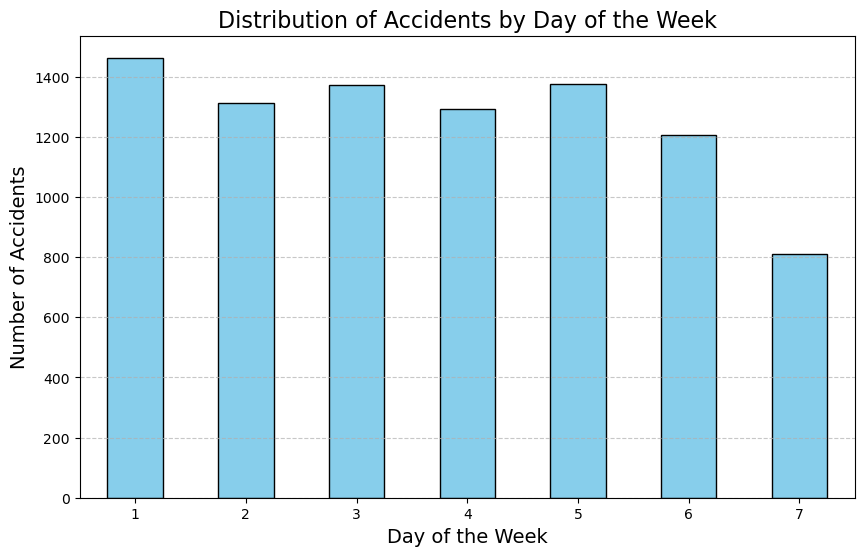

In [7]:
# Group by 'YOM_BASHAVUA' and count the number of accidents
accidents_by_day = df_dataAcc['YOM_BASHAVUA'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
accidents_by_day.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Accidents by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

****Accident Severity by Day of the Week****

In [8]:
pd.crosstab(df_dataAcc.YOM_BASHAVUA, df_dataAcc.HUMRAT_TEUNA)


HUMRAT_TEUNA,1,2,3
YOM_BASHAVUA,,,
1,56,363,1044
2,38,343,933
3,46,341,984
4,51,354,886
5,54,368,954
6,42,364,801
7,51,241,518


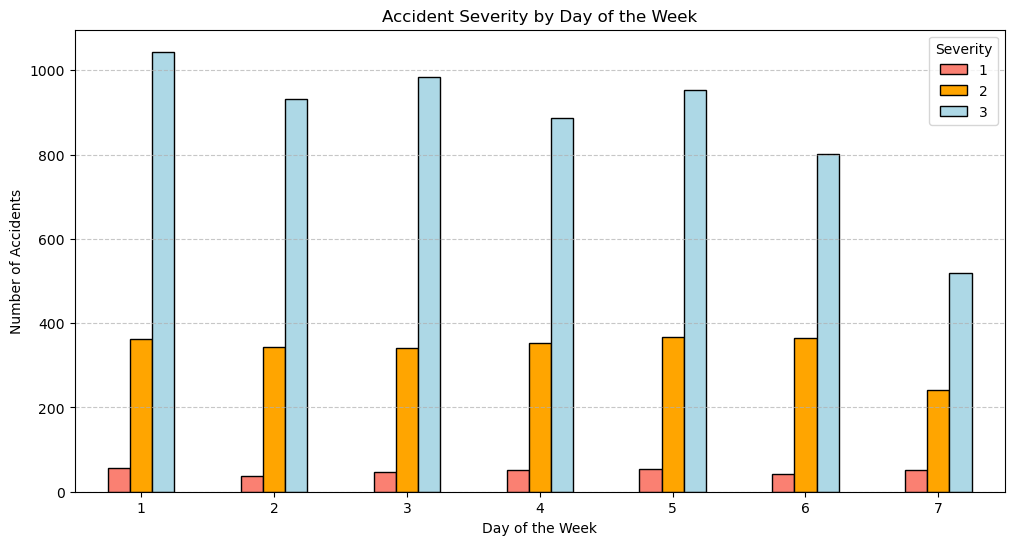

In [9]:
pd.crosstab(df_dataAcc['YOM_BASHAVUA'], df_dataAcc['HUMRAT_TEUNA']).plot(
    kind="bar", figsize=(12, 6), color=["salmon", "orange", "lightblue"] , edgecolor="black"
)
plt.title("Accident Severity by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--",  alpha=0.7)
plt.show()


****top 10 coordinates with the most accidents****

In [10]:
# Group by coordinates (X, Y) and count the number of accidents
accidents_by_coordinates = df_dataAcc.groupby(['X', 'Y']).size().reset_index(name='num_accidents')

# Sort by the number of accidents in descending order
top_coordinates = accidents_by_coordinates.sort_values(by='num_accidents', ascending=False).head(10)

# Display the top 10 coordinates with the most accidents
top_coordinates


,X,Y,num_accidents
4630,208204.0,748966.0,26
572,176674.0,588820.0,17
4514,206994.0,739830.0,17
4325,204130.0,702897.0,16
4072,200809.0,685697.0,15
1228,179991.0,662972.0,12
5050,214504.0,714033.0,11
4667,208805.0,746687.0,11
4382,205020.0,712373.0,11
5021,214065.0,745761.0,11


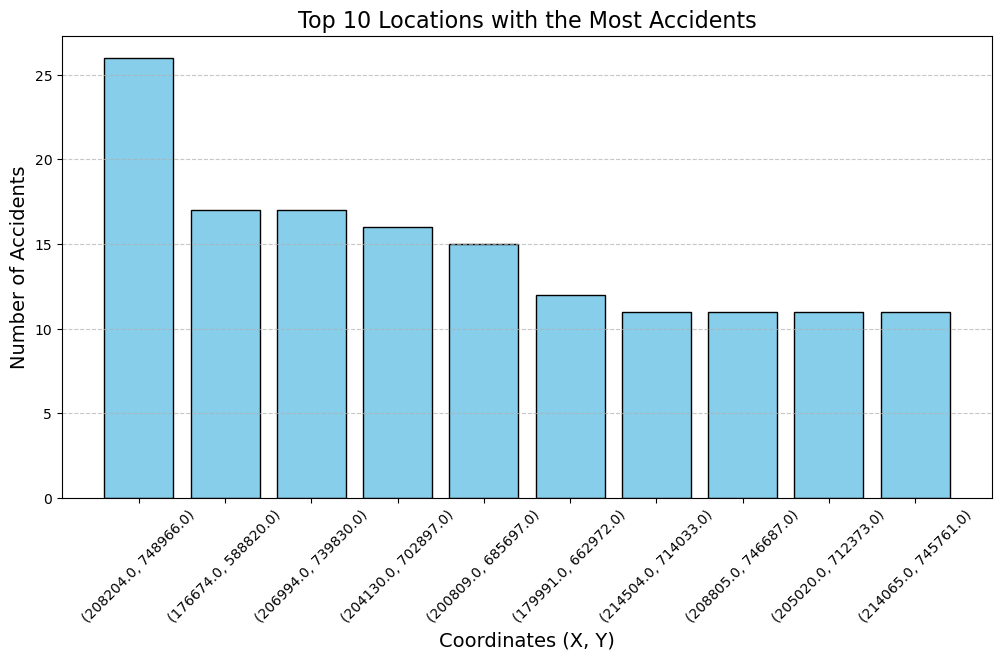

In [11]:
# Plot the top 10 coordinates with the most accidents
plt.figure(figsize=(12, 6))
plt.bar(
    top_coordinates.apply(lambda row: f"({row['X']}, {row['Y']})", axis=1),
    top_coordinates['num_accidents'],
    color="skyblue", edgecolor="black"
)
plt.title("Top 10 Locations with the Most Accidents", fontsize=16)
plt.xlabel("Coordinates (X, Y)", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



<img src="images/most_acc_overall.png" alt="most Image">

#### Intersections:


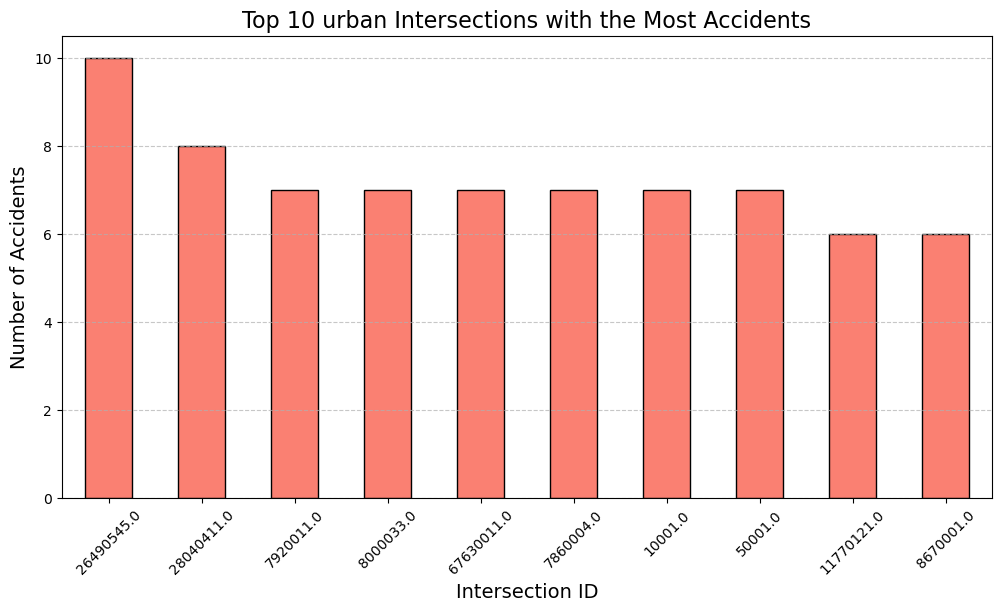

In [12]:
# Group by intersection (ZOMET_IRONI) and count the number of accidents
accidents_by_intersection = df_urban_intersections['ZOMET_IRONI'].value_counts()

# Plot the top 10 intersections with the most accidents
accidents_by_intersection.head(10).plot(kind="bar", figsize=(12, 6), color="salmon", edgecolor="black")
plt.title("Top 10 urban Intersections with the Most Accidents", fontsize=16)
plt.xlabel("Intersection ID", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



<img src="images/inter_with_most_acc.png" alt="most Image">

#### Cross the table

In [13]:
# Find common columns between the two DataFrames
common_columns = set(df_dataInv.columns).intersection(set(df_urban_intersections.columns))

# Print the common columns
print("Common columns:")
print(common_columns)


Common columns:
{'SHNAT_TEUNA', 'HODESH_TEUNA', 'pk_teuna_fikt'}


In [14]:

# Remove the specified columns from df_dataInv
df_dataInv = df_dataInv.drop(['SHNAT_TEUNA', 'HODESH_TEUNA'], axis=1)

# Check the updated DataFrame
print(f"Remaining columns: {df_dataInv.columns}")

Remaining columns: Index(['pk_teuna_fikt', 'MISPAR_REHEV_fikt', 'ZEHUT_fikt', 'SUG_MEORAV',
       'SHNAT_HOZAA', 'KVUZA_GIL', 'MIN', 'SUG_REHEV_NASA_LMS',
       'EMZAE_BETIHUT', 'SEMEL_YISHUV_MEGURIM', 'HUMRAT_PGIA', 'SUG_NIFGA_LMS',
       'PEULAT_NIFGA_LMS', 'KVUTZAT_OHLUSIYA_LMS', 'MAHOZ_MEGURIM',
       'NAFA_MEGURIM', 'EZOR_TIVI_MEGURIM', 'MAAMAD_MINIZIPALI_MEGURIM',
       'ZURAT_ISHUV_MEGURIM', 'SUG_TIK', 'ShimushBeAvizareyBetihut_LMS',
       'PtiraMeuheret_LMS'],
      dtype='object')


In [15]:
# Perform the merge
df_combined = pd.merge(
    df_urban_intersections,  # Left DataFrame
    df_dataInv,              # Right DataFrame
    on='pk_teuna_fikt',      # Common column to join on
    how='inner'              # Join type: 'inner' keeps only matching rows
)

# Display the resulting DataFrame

print(f"Number of rows: {df_combined.shape[0]}")


Number of rows: 6498


In [16]:
df_combined

,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,REHOV1,REHOV2,BAYIT,ZOMET_IRONI,KVISH1,...,PEULAT_NIFGA_LMS,KVUTZAT_OHLUSIYA_LMS,MAHOZ_MEGURIM,NAFA_MEGURIM,EZOR_TIVI_MEGURIM,MAAMAD_MINIZIPALI_MEGURIM,ZURAT_ISHUV_MEGURIM,SUG_TIK,ShimushBeAvizareyBetihut_LMS,PtiraMeuheret_LMS
0,2023000040,1,1,1,6200,312.0,221.0,NaN,7810031.0,NaN,...,8,1,5.0,51,513.0,0.0,14.0,1,NaN,NaN
1,2023000040,1,1,1,6200,312.0,221.0,NaN,7810031.0,NaN,...,1,3,5.0,51,513.0,0.0,14.0,1,NaN,NaN
2,2023000059,1,1,1,7600,505.0,205.0,NaN,7620005.0,NaN,...,9,1,2.0,24,245.0,0.0,15.0,1,1.0,NaN
3,2023000059,1,1,1,7600,505.0,205.0,NaN,7620005.0,NaN,...,8,2,2.0,23,237.0,99.0,28.0,1,NaN,NaN
4,2023000073,1,1,1,6100,825.0,856.0,NaN,9520041.0,NaN,...,9,1,NaN,99,NaN,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6493,2023099887,1,1,1,3000,1121.0,1093.0,NaN,92870888.0,NaN,...,1,1,3.0,31,311.0,0.0,13.0,1,NaN,NaN
6494,2023099916,1,1,1,3000,1863.0,1839.0,NaN,26330536.0,NaN,...,1,1,7.0,74,740.0,73.0,19.0,1,NaN,NaN
6495,2023099916,1,1,1,3000,1863.0,1839.0,NaN,26330536.0,NaN,...,8,1,2.0,23,235.0,0.0,16.0,1,NaN,NaN
6496,2023099957,1,1,1,6600,751.0,736.0,NaN,11100356.0,NaN,...,9,3,5.0,51,513.0,0.0,14.0,1,NaN,NaN


In [17]:
# Filter rows where SUG_MEORAV is either 1 or 2
df_acc_inv_drivers = df_combined[df_combined['SUG_MEORAV'].isin([1, 2])]





df_acc_inv_drivers





,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,REHOV1,REHOV2,BAYIT,ZOMET_IRONI,KVISH1,...,PEULAT_NIFGA_LMS,KVUTZAT_OHLUSIYA_LMS,MAHOZ_MEGURIM,NAFA_MEGURIM,EZOR_TIVI_MEGURIM,MAAMAD_MINIZIPALI_MEGURIM,ZURAT_ISHUV_MEGURIM,SUG_TIK,ShimushBeAvizareyBetihut_LMS,PtiraMeuheret_LMS
0,2023000040,1,1,1,6200,312.0,221.0,NaN,7810031.0,NaN,...,8,1,5.0,51,513.0,0.0,14.0,1,NaN,NaN
1,2023000040,1,1,1,6200,312.0,221.0,NaN,7810031.0,NaN,...,1,3,5.0,51,513.0,0.0,14.0,1,NaN,NaN
3,2023000059,1,1,1,7600,505.0,205.0,NaN,7620005.0,NaN,...,8,2,2.0,23,237.0,99.0,28.0,1,NaN,NaN
5,2023000073,1,1,1,6100,825.0,856.0,NaN,9520041.0,NaN,...,8,1,5.0,51,512.0,0.0,13.0,1,NaN,NaN
6,2023000076,1,1,1,70,715.0,704.0,NaN,8730052.0,NaN,...,1,3,6.0,61,613.0,0.0,13.0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,2023099887,1,1,1,3000,1121.0,1093.0,NaN,92870888.0,NaN,...,1,1,1.0,11,111.0,0.0,12.0,1,NaN,NaN
6492,2023099887,1,1,1,3000,1121.0,1093.0,NaN,92870888.0,NaN,...,1,1,1.0,11,111.0,0.0,12.0,1,1.0,NaN
6494,2023099916,1,1,1,3000,1863.0,1839.0,NaN,26330536.0,NaN,...,1,1,7.0,74,740.0,73.0,19.0,1,NaN,NaN
6495,2023099916,1,1,1,3000,1863.0,1839.0,NaN,26330536.0,NaN,...,8,1,2.0,23,235.0,0.0,16.0,1,NaN,NaN


In [18]:
# Check the distribution of SUG_MEORAV
print(df_acc_inv_drivers['SUG_MEORAV'].value_counts(normalize=True))


SUG_MEORAV
2    0.509311
1    0.490689
Name: proportion, dtype: float64


#### Plot form the driver table

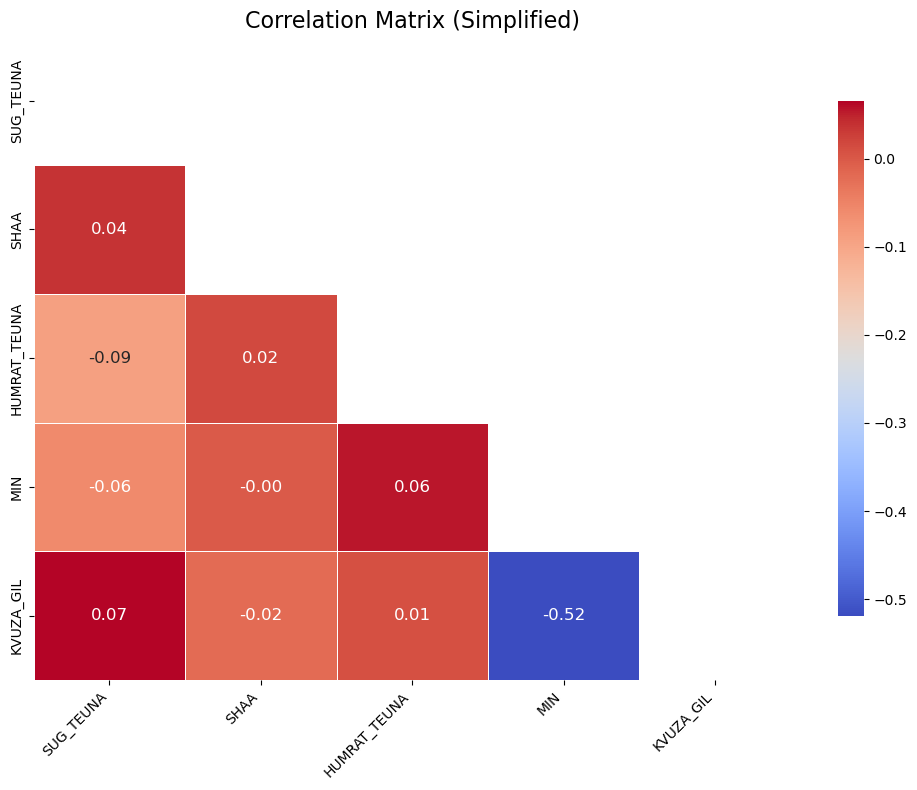

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select only relevant numeric columns
selected_columns = ['SUG_TEUNA', 'SHAA', 'HUMRAT_TEUNA', 'MIN' , 'KVUZA_GIL']  # Example columns
numeric_cols = df_acc_inv_drivers[selected_columns]

# Step 2: Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Step 3: Mask the upper triangle for clarity
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Step 4: Plot the heatmap
plt.figure(figsize=(10, 8))  # Set plot size
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
            linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={"size": 12})

# Step 5: Add titles and format
plt.title("Correlation Matrix (Simplified)", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


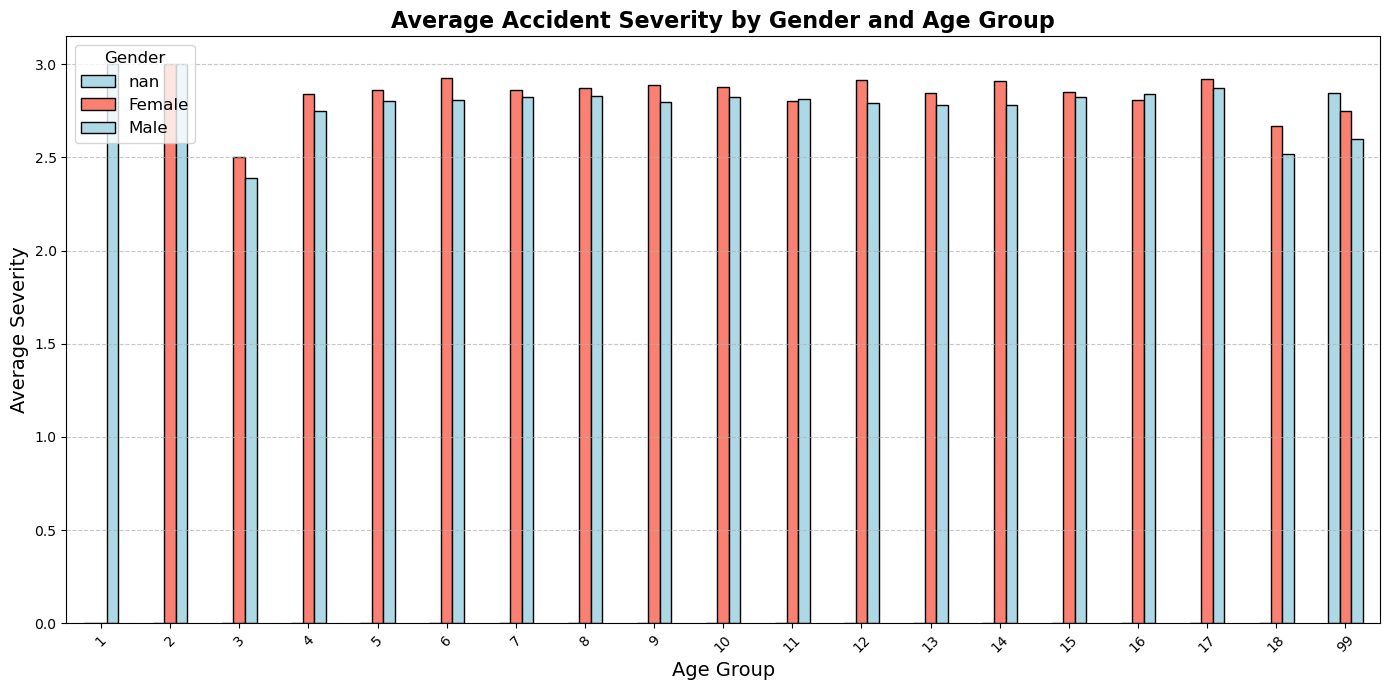

In [20]:
# Step 1: Group the data by 'MIN' (Gender) and 'KVUZA_GIL' (Age Group)
grouped_data = df_acc_inv_drivers.groupby(['MIN', 'KVUZA_GIL'])['HUMRAT_TEUNA'].mean().reset_index()

# Step 2: Rename the columns for better readability
grouped_data.columns = ['Gender', 'Age Group', 'Average Severity']

# Step 3: Map Gender for readability (1 = Male, 2 = Female)
grouped_data['Gender'] = grouped_data['Gender'].map({1: 'Male', 2: 'Female'})

# Step 4: Use a Crosstab-like Aggregation and Bar Plot
pivot_table = grouped_data.pivot(index='Age Group', columns='Gender', values='Average Severity')

# Step 5: Plot the data
pivot_table.plot(kind='bar', figsize=(14, 7), color=["lightblue", "salmon"], edgecolor="black")

# Step 6: Add titles and labels
plt.title('Average Accident Severity by Gender and Age Group', fontsize=16, weight='bold')
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Average Severity', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Gender", fontsize=12, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 7: Show the plot
plt.tight_layout()
plt.show()


C:\Users\itama\AppData\Local\Temp\ipykernel_21988\2677564178.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


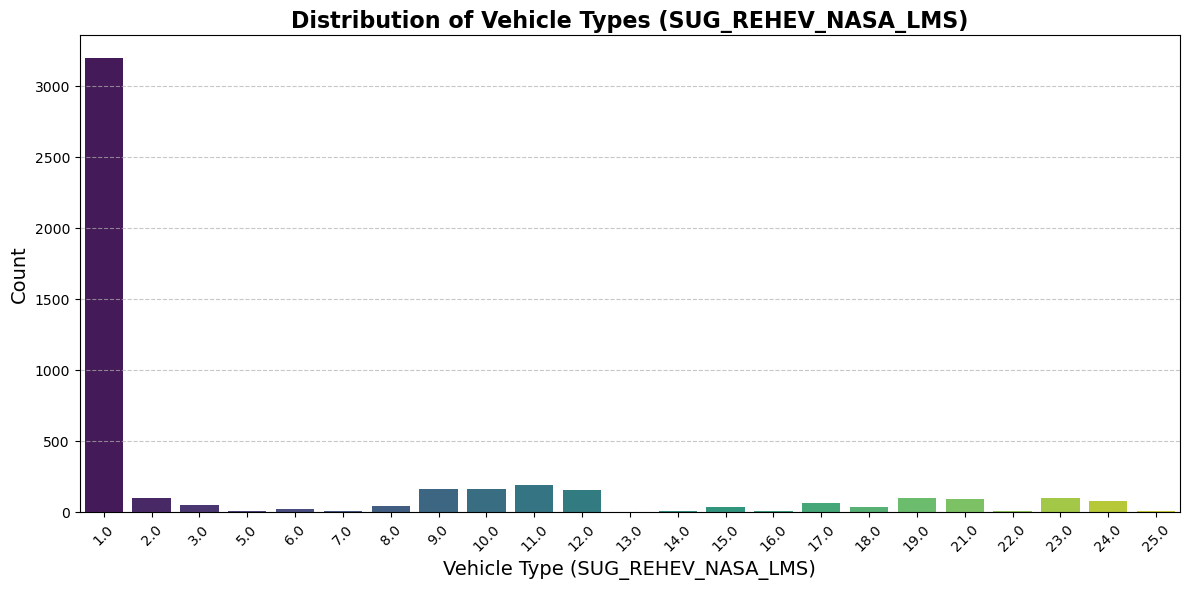

In [21]:
# Step 1: Count occurrences of each vehicle type
vehicle_counts = df_acc_inv_drivers['SUG_REHEV_NASA_LMS'].value_counts()

# Step 2: Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=vehicle_counts.index, 
    y=vehicle_counts.values, 
    palette="viridis"
)

# Step 3: Add titles and labels
plt.title('Distribution of Vehicle Types (SUG_REHEV_NASA_LMS)', fontsize=16, weight='bold')
plt.xlabel('Vehicle Type (SUG_REHEV_NASA_LMS)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Show the plot
plt.tight_layout()
plt.show()

## A.4.1 - Features - Prepering the table for Modeling (Formula + Cleaning and Rearanging)

### Creating the Target Using Our Own Formula:
<img src="images/formula.jpg" alt="tools Image">

In [22]:
# 1. Load the dataset
df = pd.read_csv("data/df_acc_inv_drivers.csv")

# 2. Create a severity score based on accident severity (1=fatal, 2=serious, 3=light)
severity_mapping = {1: 3, 2: 2, 3: 1}
df['severity_score'] = df['HUMRAT_TEUNA'].map(severity_mapping)

# 3. Calculate the severity component: score × 2
df['component_1'] = df['severity_score'] * 2

# 4. Group by intersection (urban intersection + town code)
intersection_group = df.groupby(['ZOMET_IRONI', 'SEMEL_YISHUV'])

# 5. For each intersection, count total accidents and how many were fatal, severe, and light
acc_stats = intersection_group['HUMRAT_TEUNA'].agg(
    total_acc='count',
    fatal_acc=lambda x: (x == 1).sum(),
    severe_acc=lambda x: (x == 2).sum(),
    light_acc=lambda x: (x == 3).sum()
).reset_index()

# 6. Calculate CBS-based weighted accident score + normalize it
acc_stats['weightedAccCount'] = (
    6 * acc_stats['fatal_acc'] +
    3 * acc_stats['severe_acc'] +
    1 * acc_stats['light_acc']
)

max_weighted = acc_stats['weightedAccCount'].max()
acc_stats['base_risk_score'] = (acc_stats['weightedAccCount'] / max_weighted).round(4)

# 7. Merge the stats back into the main dataframe
df = df.merge(acc_stats, on=['ZOMET_IRONI', 'SEMEL_YISHUV'], how='left')

# 8. Calculate the final hybrid risk score including accident-specific severity
df['risk_score_per_row'] = (
    df['component_1'] + 
    df['base_risk_score']
).round(2)

# 9. Save the new dataframe with the updated risk scores (optional)
#df.to_csv("data/df_with_risk_score.csv", index=False)


### Prepering our data for ML model:

In [23]:
# 2. Load the ready dataset
# ====================================

# Load the dataset we previously created
df = pd.read_csv('data/df_with_risk_score.csv')  # adjust path if needed

# ====================================
# 3. Select only the relevant columns we need for modeling
# ====================================

columns_to_keep = [
    # General identification
    'ZOMET_IRONI', 'SEMEL_YISHUV', 'X', 'Y', 'pk_teuna_fikt',
    
    # Time and Date features
    'SHNAT_TEUNA', 'HODESH_TEUNA', 'SHAA', 'SUG_YOM', 'YOM_LAYLA', 'YOM_BASHAVUA',
    
    # Road characteristics
    'SUG_DEREH', 'ZURAT_DEREH', 'HAD_MASLUL', 'RAV_MASLUL', 'MEHIRUT_MUTERET',
    'TKINUT', 'ROHAV', 'SIMUN_TIMRUR', 'TEURA', 'RAMZOR',
    
    # Environmental conditions
    'BAKARA', 'MEZEG_AVIR', 'PNE_KVISH',
    
    # Demographic location
    'NAFA',
    
    # Driver features
    'KVUZA_GIL', 'MIN','SUG_REHEV_NASA_LMS',
    
    # Target
    'base_risk_score'
]

# Keep only the selected columns
df_for_model = df[columns_to_keep].copy()

# ====================================
# 4. Create a new feature: veteran_driver_years
# ====================================

# If SHNAT_HOZAA (license issue year) exists, calculate driver experience
if 'SHNAT_HOZAA' in df.columns:
    # Replace SHNAT_HOZAA equal to 0 or 2025 with NaN to avoid unrealistic experience calculation
    df['SHNAT_HOZAA'] = df['SHNAT_HOZAA'].replace([0, 2025], np.nan)
    
    # Calculate driver experience (veteran_driver_years)
    df_for_model['veteran_driver_years'] = (2025 - df['SHNAT_HOZAA']).clip(lower=0)
else:
    # If SHNAT_HOZAA is not available, fill veteran_driver_years with None
    df_for_model['veteran_driver_years'] = None

# ====================================
# 5. Final review
# ====================================

# Display the first few rows to check
df_for_model.head()

# ====================================
# 6. (Optional) Save the cleaned dataset
# ====================================

# Save if you want to have a clean version for the model training
#df_for_model.to_csv('data/df_for_model.csv', index=False)
df_for_model.head()

,ZOMET_IRONI,SEMEL_YISHUV,X,Y,pk_teuna_fikt,SHNAT_TEUNA,HODESH_TEUNA,SHAA,SUG_YOM,YOM_LAYLA,...,RAMZOR,BAKARA,MEZEG_AVIR,PNE_KVISH,NAFA,KVUZA_GIL,MIN,SUG_REHEV_NASA_LMS,base_risk_score,veteran_driver_years
0,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,40,4,1,...,1,2.0,1,1,51,10,2,1.0,0.0690,8.0
1,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,40,4,1,...,1,2.0,1,1,51,7,1,10.0,0.0690,8.0
2,7620005.0,7600,207762.0,759167.0,2023000059,2023,3,54,4,1,...,0,1.0,1,1,24,9,1,11.0,0.0345,25.0
3,9520041.0,6100,185084.0,665378.0,2023000073,2023,5,74,4,1,...,0,1.0,1,1,51,5,1,12.0,0.0345,3.0
4,8730052.0,70,166862.0,632180.0,2023000076,2023,9,54,4,1,...,0,6.0,1,1,61,8,2,1.0,0.1379,5.0


**Convert SHAA from quarter-hour intervals (1-96) to standard hour (0-23)**

In [24]:
# Convert SHAA from quarter-hour intervals (1-96) to standard hour (0-23)
df_for_model['HOUR'] = ((df_for_model['SHAA'] - 1) // 4).astype(int)
# After checking, we can optionally drop the original 'SHAA' column
df_for_model.drop(columns=['SHAA'], inplace=True)
df_for_model



,ZOMET_IRONI,SEMEL_YISHUV,X,Y,pk_teuna_fikt,SHNAT_TEUNA,HODESH_TEUNA,SUG_YOM,YOM_LAYLA,YOM_BASHAVUA,...,BAKARA,MEZEG_AVIR,PNE_KVISH,NAFA,KVUZA_GIL,MIN,SUG_REHEV_NASA_LMS,base_risk_score,veteran_driver_years,HOUR
0,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,4,1,1,...,2.0,1,1,51,10,2,1.0,0.0690,8.0,9
1,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,4,1,1,...,2.0,1,1,51,7,1,10.0,0.0690,8.0,9
2,7620005.0,7600,207762.0,759167.0,2023000059,2023,3,4,1,5,...,1.0,1,1,24,9,1,11.0,0.0345,25.0,13
3,9520041.0,6100,185084.0,665378.0,2023000073,2023,5,4,1,2,...,1.0,1,1,51,5,1,12.0,0.0345,3.0,18
4,8730052.0,70,166862.0,632180.0,2023000076,2023,9,4,1,2,...,6.0,1,1,61,8,2,1.0,0.1379,5.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,92870888.0,3000,217745.0,631262.0,2023099887,2023,7,4,1,1,...,2.0,1,1,11,8,1,1.0,0.2069,19.0,15
4614,92870888.0,3000,217745.0,631262.0,2023099887,2023,7,4,1,1,...,2.0,1,1,11,13,2,1.0,0.2069,47.0,15
4615,26330536.0,3000,220351.0,628200.0,2023099916,2023,3,4,1,4,...,3.0,2,1,11,5,2,19.0,0.0690,7.0,8
4616,26330536.0,3000,220351.0,628200.0,2023099916,2023,3,4,1,4,...,3.0,2,1,11,13,1,1.0,0.0690,44.0,8


In [25]:
#save
#df_for_model.to_csv('data/df_for_model.csv', index=False)

In [26]:
# info.. 
df_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4618 entries, 0 to 4617
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ZOMET_IRONI           4618 non-null   float64
 1   SEMEL_YISHUV          4618 non-null   int64  
 2   X                     4618 non-null   float64
 3   Y                     4618 non-null   float64
 4   pk_teuna_fikt         4618 non-null   int64  
 5   SHNAT_TEUNA           4618 non-null   int64  
 6   HODESH_TEUNA          4618 non-null   int64  
 7   SUG_YOM               4618 non-null   int64  
 8   YOM_LAYLA             4618 non-null   int64  
 9   YOM_BASHAVUA          4618 non-null   int64  
 10  SUG_DEREH             4618 non-null   int64  
 11  ZURAT_DEREH           4618 non-null   int64  
 12  HAD_MASLUL            4618 non-null   int64  
 13  RAV_MASLUL            4618 non-null   int64  
 14  MEHIRUT_MUTERET       4618 non-null   int64  
 15  TKINUT               

In [27]:
df_for_model.isna().sum()

ZOMET_IRONI               0
SEMEL_YISHUV              0
X                         0
Y                         0
pk_teuna_fikt             0
SHNAT_TEUNA               0
HODESH_TEUNA              0
SUG_YOM                   0
YOM_LAYLA                 0
YOM_BASHAVUA              0
SUG_DEREH                 0
ZURAT_DEREH               0
HAD_MASLUL                0
RAV_MASLUL                0
MEHIRUT_MUTERET           0
TKINUT                    0
ROHAV                     0
SIMUN_TIMRUR              0
TEURA                     0
RAMZOR                    0
BAKARA                  146
MEZEG_AVIR                0
PNE_KVISH                 0
NAFA                      0
KVUZA_GIL                 0
MIN                       0
SUG_REHEV_NASA_LMS        0
base_risk_score           0
veteran_driver_years    422
HOUR                      0
dtype: int64

## A.4.2 - Advance Feature Engineering

### Cyclical Encoding for HODESH_TEUNA:
- This feature is **ordinal** (has a natural order from 1 to 12)  
- But also **cyclical** — December (12) and January (1) are neighbors

---

####  Why raw numeric encoding is problematic:
- A model may assume that month 12 is *much larger* than 1, which is **not true** for months
- The distance between month 1 and 12 is falsely perceived as large

---

####  Why not use One-Hot Encoding?
- Creates **12 new columns**
- **No natural proximity** is preserved (e.g., December ≠ close to January)

---

####  Solution: **Cyclical Encoding**
We use sine and cosine to represent the month on a circular scale:

In [28]:
# Convert month (1 to 12) into cyclical features using sine and cosine
df_for_model['HODESH_TEUNA_sin'] = np.sin(2 * np.pi * df_for_model['HODESH_TEUNA'] / 12)
df_for_model['HODESH_TEUNA_cos'] = np.cos(2 * np.pi * df_for_model['HODESH_TEUNA'] / 12)

# Optional: Drop the original 'HODESH_TEUNA' column if you no longer need it
#df_for_model.drop(columns=['HODESH_TEUNA'], inplace=True)
df_for_model

,ZOMET_IRONI,SEMEL_YISHUV,X,Y,pk_teuna_fikt,SHNAT_TEUNA,HODESH_TEUNA,SUG_YOM,YOM_LAYLA,YOM_BASHAVUA,...,PNE_KVISH,NAFA,KVUZA_GIL,MIN,SUG_REHEV_NASA_LMS,base_risk_score,veteran_driver_years,HOUR,HODESH_TEUNA_sin,HODESH_TEUNA_cos
0,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,4,1,1,...,1,51,10,2,1.0,0.0690,8.0,9,0.500000,8.660254e-01
1,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,4,1,1,...,1,51,7,1,10.0,0.0690,8.0,9,0.500000,8.660254e-01
2,7620005.0,7600,207762.0,759167.0,2023000059,2023,3,4,1,5,...,1,24,9,1,11.0,0.0345,25.0,13,1.000000,6.123234e-17
3,9520041.0,6100,185084.0,665378.0,2023000073,2023,5,4,1,2,...,1,51,5,1,12.0,0.0345,3.0,18,0.500000,-8.660254e-01
4,8730052.0,70,166862.0,632180.0,2023000076,2023,9,4,1,2,...,1,61,8,2,1.0,0.1379,5.0,13,-1.000000,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,92870888.0,3000,217745.0,631262.0,2023099887,2023,7,4,1,1,...,1,11,8,1,1.0,0.2069,19.0,15,-0.500000,-8.660254e-01
4614,92870888.0,3000,217745.0,631262.0,2023099887,2023,7,4,1,1,...,1,11,13,2,1.0,0.2069,47.0,15,-0.500000,-8.660254e-01
4615,26330536.0,3000,220351.0,628200.0,2023099916,2023,3,4,1,4,...,1,11,5,2,19.0,0.0690,7.0,8,1.000000,6.123234e-17
4616,26330536.0,3000,220351.0,628200.0,2023099916,2023,3,4,1,4,...,1,11,13,1,1.0,0.0690,44.0,8,1.000000,6.123234e-17


In [29]:
#When using the model later (e.g., for December)
month = 12  # December
sin_val = np.sin(2 * np.pi * month / 12)
cos_val = np.cos(2 * np.pi * month / 12)

print("sin:", sin_val)
print("cos:", cos_val)

sin: -2.4492935982947064e-16
cos: 1.0


### SUG YOM
 Feature type: Categorical (Nominal).
- Original values:
  - 4 → Weekday
  - 3 → IntermediateHoliday (Chol HaMoed)
  - 2 → HolidayEve
  - 1 → Holiday
- Reasoning:
  - There is no mathematical order or meaningful numeric distance between values.
  - We used One Hot Encoding to preserve the independence of each category.
  - This allows the model to learn separate coefficients per type without assuming any implicit ranking.

In [30]:
df['SUG_YOM'].value_counts()


SUG_YOM
4    4363
2     102
3      88
1      65
Name: count, dtype: int64

In [31]:
# Map numeric values to English labels
df_for_model['SUG_YOM'] = df_for_model['SUG_YOM'].map({
    4: 'Weekday',
    3: 'IntermediateHoliday',
    2: 'HolidayEve',
    1: 'Holiday'
})

# One Hot Encoding
df_for_model = pd.get_dummies(df_for_model, columns=['SUG_YOM'], prefix='SUG_YOM', dtype=int)
df_for_model.head()

,ZOMET_IRONI,SEMEL_YISHUV,X,Y,pk_teuna_fikt,SHNAT_TEUNA,HODESH_TEUNA,YOM_LAYLA,YOM_BASHAVUA,SUG_DEREH,...,SUG_REHEV_NASA_LMS,base_risk_score,veteran_driver_years,HOUR,HODESH_TEUNA_sin,HODESH_TEUNA_cos,SUG_YOM_Holiday,SUG_YOM_HolidayEve,SUG_YOM_IntermediateHoliday,SUG_YOM_Weekday
0,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,1,1,1,...,1.0,0.0690,8.0,9,0.5,8.660254e-01,0,0,0,1
1,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,1,1,1,...,10.0,0.0690,8.0,9,0.5,8.660254e-01,0,0,0,1
2,7620005.0,7600,207762.0,759167.0,2023000059,2023,3,1,5,1,...,11.0,0.0345,25.0,13,1.0,6.123234e-17,0,0,0,1
3,9520041.0,6100,185084.0,665378.0,2023000073,2023,5,1,2,1,...,12.0,0.0345,3.0,18,0.5,-8.660254e-01,0,0,0,1
4,8730052.0,70,166862.0,632180.0,2023000076,2023,9,1,2,1,...,1.0,0.1379,5.0,13,-1.0,-1.836970e-16,0,0,0,1


### Feature: YOM_LAYLA (Day vs. Night)

- Original values:
  - 1 = Day
  - 5 = Night
- Since this is a binary feature, we created a new column `is_night`:
  - 1 = Night
  - 0 = Day
- This avoids relying on the arbitrary numeric values (1, 5).

In [32]:
df['YOM_LAYLA'].value_counts()


YOM_LAYLA
1    3004
5    1614
Name: count, dtype: int64

In [33]:
# Create binary feature: is_night = 1 if value is 5 (night), else 0
df_for_model['is_night'] = (df_for_model['YOM_LAYLA'] == 5).astype(int)

# Drop original column
df_for_model.drop(columns=['YOM_LAYLA'], inplace=True)

In [34]:
df_for_model

,ZOMET_IRONI,SEMEL_YISHUV,X,Y,pk_teuna_fikt,SHNAT_TEUNA,HODESH_TEUNA,YOM_BASHAVUA,SUG_DEREH,ZURAT_DEREH,...,base_risk_score,veteran_driver_years,HOUR,HODESH_TEUNA_sin,HODESH_TEUNA_cos,SUG_YOM_Holiday,SUG_YOM_HolidayEve,SUG_YOM_IntermediateHoliday,SUG_YOM_Weekday,is_night
0,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,1,1,8,...,0.0690,8.0,9,0.500000,8.660254e-01,0,0,0,1,0
1,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,1,1,8,...,0.0690,8.0,9,0.500000,8.660254e-01,0,0,0,1,0
2,7620005.0,7600,207762.0,759167.0,2023000059,2023,3,5,1,8,...,0.0345,25.0,13,1.000000,6.123234e-17,0,0,0,1,0
3,9520041.0,6100,185084.0,665378.0,2023000073,2023,5,2,1,8,...,0.0345,3.0,18,0.500000,-8.660254e-01,0,0,0,1,0
4,8730052.0,70,166862.0,632180.0,2023000076,2023,9,2,1,8,...,0.1379,5.0,13,-1.000000,-1.836970e-16,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,92870888.0,3000,217745.0,631262.0,2023099887,2023,7,1,1,8,...,0.2069,19.0,15,-0.500000,-8.660254e-01,0,0,0,1,0
4614,92870888.0,3000,217745.0,631262.0,2023099887,2023,7,1,1,8,...,0.2069,47.0,15,-0.500000,-8.660254e-01,0,0,0,1,0
4615,26330536.0,3000,220351.0,628200.0,2023099916,2023,3,4,1,9,...,0.0690,7.0,8,1.000000,6.123234e-17,0,0,0,1,0
4616,26330536.0,3000,220351.0,628200.0,2023099916,2023,3,4,1,9,...,0.0690,44.0,8,1.000000,6.123234e-17,0,0,0,1,0


### Feature: YOM_BASHAVUA (Day of the Week)

- Original values:
  - 1 = Sunday, 2 = Monday, ..., 7 = Saturday
- Since this is a cyclical feature (e.g., Sunday and Saturday are close), we used **Cyclical Encoding** with sine and cosine.
- This prevents the model from assuming that day 7 is "further" from day 1 than day 2 is.

- When predicting new data, you must convert the incoming day (1–7) to the corresponding sine and cosine values:
  
day_input = 1  # Sunday, for example

day_sin = np.sin(2 * np.pi * day_input / 7)

day_cos = np.cos(2 * np.pi * day_input / 7)

In [35]:
df['YOM_BASHAVUA'].value_counts()


YOM_BASHAVUA
1    801
3    739
5    716
2    697
4    670
6    610
7    385
Name: count, dtype: int64

In [36]:
df_for_model['YOM_BASHAVUA_sin'] = np.sin(2 * np.pi * df_for_model['YOM_BASHAVUA'] / 7)
df_for_model['YOM_BASHAVUA_cos'] = np.cos(2 * np.pi * df_for_model['YOM_BASHAVUA'] / 7)
df_for_model.head()

,ZOMET_IRONI,SEMEL_YISHUV,X,Y,pk_teuna_fikt,SHNAT_TEUNA,HODESH_TEUNA,YOM_BASHAVUA,SUG_DEREH,ZURAT_DEREH,...,HOUR,HODESH_TEUNA_sin,HODESH_TEUNA_cos,SUG_YOM_Holiday,SUG_YOM_HolidayEve,SUG_YOM_IntermediateHoliday,SUG_YOM_Weekday,is_night,YOM_BASHAVUA_sin,YOM_BASHAVUA_cos
0,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,1,1,8,...,9,0.5,8.660254e-01,0,0,0,1,0,0.781831,0.623490
1,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,1,1,8,...,9,0.5,8.660254e-01,0,0,0,1,0,0.781831,0.623490
2,7620005.0,7600,207762.0,759167.0,2023000059,2023,3,5,1,8,...,13,1.0,6.123234e-17,0,0,0,1,0,-0.974928,-0.222521
3,9520041.0,6100,185084.0,665378.0,2023000073,2023,5,2,1,8,...,18,0.5,-8.660254e-01,0,0,0,1,0,0.974928,-0.222521
4,8730052.0,70,166862.0,632180.0,2023000076,2023,9,2,1,8,...,13,-1.0,-1.836970e-16,0,0,0,1,0,0.974928,-0.222521


In [37]:
df_for_model.drop(columns=['SUG_DEREH'], inplace=True)
# לא חשוב 

In [38]:
# REMOVE ZURAT_DEREH - not clear what it is ...
df_for_model.drop(columns=['ZURAT_DEREH'], inplace=True)


### Feature: HAD_MASLUL (Lane Structure - Cleaned)

- Original values:
  - 0 = Multi-lane one-way
  - 1 = Single-lane one-way
  - 2 = Two-way with separator (no overtaking)
  - 3 = Two-way without separator (overtaking allowed)
  - 9 = Unknown → removed

- We decided to:
  - Remove all rows where `HAD_MASLUL` = 9 (unknown)
  - Keep values 0–3 and apply One Hot Encoding
  - Use `dtype=int` to ensure binary format (0/1)

In [39]:
df['HAD_MASLUL'].value_counts()


HAD_MASLUL
0    1978
3    1586
1     785
9     194
2      75
Name: count, dtype: int64

In [40]:
# הסרת שורות עם ערך 9
df_for_model = df_for_model[df_for_model['HAD_MASLUL'] != 9].copy()

# מיפוי ערכים לשמות ברורים
maslul_mapping = {
    0: 'MultiLaneOneWay',
    1: 'SingleLaneOneWay',
    2: 'TwoWay_Separated',
    3: 'TwoWay_Unseparated'
}
df_for_model.loc[:, 'HAD_MASLUL'] = df_for_model['HAD_MASLUL'].map(maslul_mapping)

# One Hot Encoding
df_for_model = pd.get_dummies(df_for_model, columns=['HAD_MASLUL'], prefix='', dtype=int)


C:\Users\itama\AppData\Local\Temp\ipykernel_21988\3092757168.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['MultiLaneOneWay' 'MultiLaneOneWay' 'SingleLaneOneWay' ...
 'SingleLaneOneWay' 'SingleLaneOneWay' 'MultiLaneOneWay']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_for_model.loc[:, 'HAD_MASLUL'] = df_for_model['HAD_MASLUL'].map(maslul_mapping)


In [41]:
df_for_model

,ZOMET_IRONI,SEMEL_YISHUV,X,Y,pk_teuna_fikt,SHNAT_TEUNA,HODESH_TEUNA,YOM_BASHAVUA,RAV_MASLUL,MEHIRUT_MUTERET,...,SUG_YOM_HolidayEve,SUG_YOM_IntermediateHoliday,SUG_YOM_Weekday,is_night,YOM_BASHAVUA_sin,YOM_BASHAVUA_cos,_MultiLaneOneWay,_SingleLaneOneWay,_TwoWay_Separated,_TwoWay_Unseparated
0,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,1,3,1,...,0,0,1,0,0.781831,0.623490,1,0,0,0
1,7810031.0,6200,175748.0,657646.0,2023000040,2023,1,1,3,1,...,0,0,1,0,0.781831,0.623490,1,0,0,0
2,7620005.0,7600,207762.0,759167.0,2023000059,2023,3,5,0,1,...,0,0,1,0,-0.974928,-0.222521,0,1,0,0
3,9520041.0,6100,185084.0,665378.0,2023000073,2023,5,2,0,1,...,0,0,1,0,0.974928,-0.222521,0,1,0,0
4,8730052.0,70,166862.0,632180.0,2023000076,2023,9,2,0,1,...,0,0,1,0,0.974928,-0.222521,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,92870888.0,3000,217745.0,631262.0,2023099887,2023,7,1,0,1,...,0,0,1,0,0.781831,0.623490,0,0,0,1
4614,92870888.0,3000,217745.0,631262.0,2023099887,2023,7,1,0,1,...,0,0,1,0,0.781831,0.623490,0,0,0,1
4615,26330536.0,3000,220351.0,628200.0,2023099916,2023,3,4,0,1,...,0,0,1,0,-0.433884,-0.900969,0,1,0,0
4616,26330536.0,3000,220351.0,628200.0,2023099916,2023,3,4,0,1,...,0,0,1,0,-0.433884,-0.900969,0,1,0,0


In [42]:
df_for_model.drop(columns=['RAV_MASLUL'], inplace=True)
# Dropped Feature: RAV_MASLUL (Multi-Lane Indicator)

### Feature: MEHIRUT_MUTERET (Speed Limit Category)

- Original values:
  - 1 = up to 50 km/h
  - 2 = up to 60 km/h
  - 3 = up to 70 km/h
  - 4 = up to 80 km/h
  - 5 = up to 90 km/h
  - 6 = up to 100 km/h
  - 7 = up to 110 km/h
  - 8 / 0 = unknown or invalid → removed

- We removed rows with invalid values (0 and 8) and kept values 1–7 as-is, treating the feature as ordinal.

In [43]:
# הסרת שורות עם ערכים לא תקינים (0 ו-8)
df_for_model = df_for_model[~df_for_model['MEHIRUT_MUTERET'].isin([0, 8])]


In [44]:
df_for_model['MEHIRUT_MUTERET'].value_counts()



MEHIRUT_MUTERET
1    3636
3     343
2     272
6      63
7      41
4      25
5      18
Name: count, dtype: int64

### Feature: TKINUT (Road Condition)


- Original values:
  - 1 = Good
  - 2 = Bad shoulders
  - 3 = Bumpy or damaged road
  - 0 = Unknown → removed

- We created a new binary feature `is_bad_road`:
  - `0` → Good condition (original code 1)
  - `1` → Bad condition (original codes 2 or 3)

In [45]:
# הסרת שורות עם ערך 0 (לא ידוע)
df_for_model = df_for_model[df_for_model['TKINUT'] != 0].copy()

# יצירת עמודה בינארית: 0 = תקין, 1 = לא תקין
df_for_model['is_bad_road'] = df_for_model['TKINUT'].apply(lambda x: 1 if x in [2, 3] else 0)

# הסרת העמודה המקורית
df_for_model.drop(columns=['TKINUT'], inplace=True)


In [46]:
#df_for_model['TKINUT'].value_counts()

### Feature: ROHAV (Road Width Category)

- Original values:
  - 1 = up to 5 meters
  - 2 = 5–7 meters
  - 3 = 7–10.5 meters
  - 4 = 10.5–14 meters
  - 5 = above 14 meters
  - 0 = Unknown → removed

- We chose to:
  - Remove all rows with value 0 (unknown)
  - Keep values 1–5 as ordinal categories, preserving their inherent order

In [47]:
df_for_model['ROHAV'].value_counts()

ROHAV
2    1487
3    1381
4     582
5     446
0     186
1     124
Name: count, dtype: int64

In [48]:
# הסרת שורות עם ערך 0 (לא ידוע)
df_for_model = df_for_model[df_for_model['ROHAV'] != 0].copy()


### Feature: SIMUN_TIMRUR (Signage/Marking Quality)

- Original values:
  - 1 = Faulty or missing road markings
  - 2 = Faulty or missing traffic signs
  - 3 = No defect
  - 4 = Signage not required
  - 5 = Unknown → removed

- We created a binary feature `is_signage_problem`:
  - `1` → Any kind of signage or marking defect (codes 1 or 2)
  - `0` → No defect or signage not required (codes 3 or 4)

In [49]:
df_for_model['SIMUN_TIMRUR'].value_counts()

SIMUN_TIMRUR
3    3499
5     272
4     192
2      29
1      28
Name: count, dtype: int64

In [50]:
# הסרת שורות עם ערך 5 (לא ידוע)
df_for_model = df_for_model[df_for_model['SIMUN_TIMRUR'] != 5].copy()

# עמודה בינארית: האם יש בעיה בסימון/תמרור
df_for_model['is_signage_problem'] = df_for_model['SIMUN_TIMRUR'].apply(lambda x: 1 if x in [1, 2] else 0)

# הסרת העמודה המקורית
df_for_model.drop(columns=['SIMUN_TIMRUR'], inplace=True)


### Dropped Feature: TEURA (Lighting Conditions)

- This feature included many sparse and unclear categories (values 1–11).
- Due to lack of documentation and category imbalance, we removed it for now.
- We may revisit this feature in the future if we obtain a clear mapping.

In [51]:
df_for_model.drop(columns=['TEURA'], inplace=True)

### BAKARA

In [52]:
df_for_model.drop(columns=['BAKARA'], inplace=True)

### Feature: MEZEG_AVIR (Weather Condition)

- Original values:
  - 1 = Clear
  - 2 = Rainy
  - 3 = Hot
  - 4 = Foggy
  - 5 = Other
  - 9 = Unknown → removed

- We created a binary feature `is_not_clear_weather`:
  - `0` → Clear weather (original value 1)
  - `1` → Non-clear weather (values 2–5)

In [53]:
df_for_model['MEZEG_AVIR'].value_counts()

MEZEG_AVIR
1    3437
9     167
2     125
5      14
3       3
4       2
Name: count, dtype: int64

In [54]:
# הסרת שורות עם ערך 9 (לא ידוע)
df_for_model = df_for_model[df_for_model['MEZEG_AVIR'] != 9].copy()

# יצירת עמודה בינארית: 0 = בהיר, 1 = לא בהיר
df_for_model['is_not_clear_weather'] = df_for_model['MEZEG_AVIR'].apply(lambda x: 0 if x == 1 else 1)

# הסרת העמודה המקורית
df_for_model.drop(columns=['MEZEG_AVIR'], inplace=True)


### Feature: PNE_KVISH (Road Surface Condition)

- Original values:
  - 1 = Dry
  - 2 = Wet
  - 3 = Fuel-covered (not present)
  - 4 = Mud (not present)
  - 5 = Sand/Gravel
  - 6 = Other
  - 9 = Unknown → removed

- We created a binary feature `is_slippery_road`:
  - `0` → Dry road
  - `1` → Any potentially slippery condition (wet, gravel, other) 2-6

- Code:
```python
df_for_model = df_for_model[df_for_model['PNE_KVISH'] != 9].copy()
df_for_model['is_slippery_road'] = df_for_model['PNE_KVISH'].apply(lambda x: 0 if x == 1 else 1)
df_for_model.drop(columns=['PNE_KVISH'], inplace=True)


In [55]:
df_for_model['PNE_KVISH'].value_counts()

PNE_KVISH
1    3418
2     130
9      15
6      12
5       6
Name: count, dtype: int64

In [56]:
# הסרת שורות עם ערך 9 (לא ידוע)
df_for_model = df_for_model[df_for_model['PNE_KVISH'] != 9].copy()

# עמודה בינארית: 0 = יבש, 1 = לא יבש (עלול להחליק)
df_for_model['is_slippery_road'] = df_for_model['PNE_KVISH'].apply(lambda x: 0 if x == 1 else 1)

# הסרת העמודה המקורית
df_for_model.drop(columns=['PNE_KVISH'], inplace=True)


### Dropped Feature: NAFA (Geographic District)

- This column represents geographic zones (districts or regions).
- We chose to remove it due to:
  - Limited relevance to intersection-level danger prediction
  - Potential for data imbalance or overfitting by location
  - Simpler, location-agnostic model


In [57]:
df_for_model.drop(columns=['NAFA'], inplace=True)


### Feature: KVUZA_GIL (Age Group)

- Original values (1–18) represent 5-year age ranges:
  - 1 = 00–04, 2 = 05–09, ..., 18 = 85+
  - 99 = Unknown → removed

- We kept the ordinal values 1–18 as-is, preserving age order.
- This allows the model to learn age-related patterns without overcomplicating the encoding.

- Code:
```python
df_for_model = df_for_model[df_for_model['KVUZA_GIL'] != 99].copy()


In [58]:
df_for_model['KVUZA_GIL'].value_counts()

KVUZA_GIL
5     435
6     426
7     346
8     302
9     285
10    264
12    228
11    208
13    201
4     181
14    166
15    165
99    148
16    117
17     48
18     24
3      16
2       5
1       1
Name: count, dtype: int64

In [59]:
# הסרת ערכים לא ידועים
df_for_model = df_for_model[df_for_model['KVUZA_GIL'] != 99].copy()


In [60]:
# df_for_model.to_csv('data/df_for_model.csv', index=False)

###  RAMZOR Feature

The `RAMZOR` column indicates the presence of a traffic light at the intersection:
- `0` = No traffic light
- `1` = Traffic light present
- `9` = Unknown / missing value

To ensure this feature is usable in modeling, we removed all rows where `RAMZOR` equals 9.

```python
df_for_model = df_for_model[df_for_model['RAMZOR'].isin([0, 1])]


In [61]:
# Remove rows where RAMZOR is 9 (unknown) from df_for_model
df_for_model = df_for_model[df_for_model['RAMZOR'].isin([0, 1])]


### Feature: MIN → SEX (Driver's Gender)

- Original values:
  - 1 = Male
  - 2 = Female

- We renamed and recoded this feature as `SEX`:
  - `0` → Male
  - `1` → Female

- Code:
```python
df_for_model['SEX'] = df_for_model['MIN'].apply(lambda x: 1 if x == 2 else 0)
df_for_model.drop(columns=['MIN'], inplace=True)


In [62]:
df_for_model['MIN'].value_counts()

MIN
1    2340
2     966
Name: count, dtype: int64

In [63]:
# יצירת עמודה חדשה בשם 'SEX': 0 = Male, 1 = Female
df_for_model['SEX'] = df_for_model['MIN'].apply(lambda x: 1 if x == 2 else 0)

# הסרת העמודה המקורית
df_for_model.drop(columns=['MIN'], inplace=True)


### Feature: vehicle_category (Grouped from SUG_REHEV_NASA_LMS)

We grouped 25 original vehicle types into 3 general categories:

- **0 = private_or_taxi**:
  - Codes: 1 (private car), 12 (taxi)

- **1 = two_wheels**:
  - Motorcycle-related:
    - 8 = light motorcycle
    - 9 = heavy motorcycle
    - 10 = very heavy motorcycle
    - 19 = extra heavy motorcycle
  - Bicycle/micro-mobility:
    - 15 = bicycle
    - 21 = electric scooter
    - 22 = motorized wheelchair
    - 23 = electric bicycle

- **2 = heavy_or_other**:
  - All remaining vehicle types, including:
    - 2, 3, 5, 6, 7, 11, 13, 14, 16, 17, 18, 24, 25
    - Representing trucks, vans, buses, tractors, work vehicles, trains, and miscellaneous

**Encoding:**
We applied **One-Hot Encoding** to the `vehicle_category` column using `pd.get_dummies()`, which resulted in:

- `vehicle_0` → 1 if private_or_taxi, else 0  
- `vehicle_1` → 1 if two_wheels, else 0  
- `vehicle_2` → 1 if heavy_or_other, else 0  

> Keeping all three columns allows the model to fully represent all classes without assuming any are "baseline". This works well for models that can handle multicollinearity or when interpretability is prioritized.


In [64]:
df_for_model['SUG_REHEV_NASA_LMS'].value_counts()

SUG_REHEV_NASA_LMS
1.0     2373
11.0     128
9.0      115
10.0     112
12.0     111
2.0       72
19.0      70
23.0      60
21.0      58
24.0      51
3.0       37
18.0      26
15.0      24
8.0       18
6.0       16
17.0       7
7.0        7
14.0       7
22.0       5
16.0       3
25.0       3
5.0        2
13.0       1
Name: count, dtype: int64

In [65]:
# Step 1: Create the simplified vehicle category
def simplify_vehicle_category(x):
    if x in [1, 12]:
        return 0  # private_or_taxi
    elif x in [8, 9, 10, 15, 19, 21, 22, 23]:
        return 1  # two_wheels
    else:
        return 2  # heavy_or_other

df_for_model['vehicle_category'] = df_for_model['SUG_REHEV_NASA_LMS'].apply(simplify_vehicle_category)

# Step 2: Drop the original column
df_for_model.drop(columns=['SUG_REHEV_NASA_LMS'], inplace=True)

# ✅ Step 3: Apply One-Hot Encoding
df_for_model = pd.get_dummies(df_for_model, columns=['vehicle_category'], prefix='vehicle')

# ✅ Step 4: Convert One-Hot columns from bool to int
for col in ['vehicle_0', 'vehicle_1', 'vehicle_2']:
    df_for_model[col] = df_for_model[col].astype(int)


# ✅ Step 4 (optional): Drop one column to avoid multicollinearity (for Logistic Regression)
#df_for_model.drop(columns=['vehicle_0'], inplace=True)  # vehicle_0 = private_or_taxi (baseline class)


### Feature: veteran_driver_years

- Represents the number of years the driver has held a valid license.
- We kept the feature as-is (numeric, continuous).
- Missing values (137 rows) were removed from the dataset.


In [66]:
df_for_model['veteran_driver_years'].value_counts()

veteran_driver_years
6.0     193
4.0     161
7.0     149
8.0     111
5.0     110
       ... 
66.0      2
67.0      2
1.0       2
64.0      1
71.0      1
Name: count, Length: 70, dtype: int64

In [67]:
# בדיקה מהירה אם יש ערכים חסרים
df_for_model['veteran_driver_years'].isnull().sum()

np.int64(132)

In [68]:
# הסרת שורות עם ערכים חסרים בעמודת veteran_driver_years
df_for_model = df_for_model[df_for_model['veteran_driver_years'].notna()].copy()


### Feature: HOUR (Time of Accident)

- Original range: 0–23
- We applied cyclical encoding to capture the circular nature of time:
  - `hour_sin = sin(2π * HOUR / 24)`
  - `hour_cos = cos(2π * HOUR / 24)`

In [69]:
df_for_model['hour_sin'] = np.sin(2 * np.pi * df_for_model['HOUR'] / 24)
df_for_model['hour_cos'] = np.cos(2 * np.pi * df_for_model['HOUR'] / 24)

In [70]:
#df_for_model.to_csv('data/df_for_model.csv', index=False)

### 🎯 Target Transformation: `base_risk_score` → `risk_level` (3-class classification)

We converted the continuous numeric target `base_risk_score` into a categorical variable `risk_level` with **3 classes**: low, medium, and high risk.

---

### 🧠 Method: Quantile-Based Binning

This method is called **quantile-based binning** (or quantile discretization).  
It divides a numeric distribution into intervals that each contain roughly the same number of samples.

#### Why it's a professional and proven technique:
- 📊 **Data-driven**: the thresholds are determined directly from the data distribution  
- ⚖️ **Balanced classes**: avoids class imbalance, which is a common issue in classification tasks  
- 🚫 **No manual bias**: thresholds are not arbitrary or subjective  
- ✅ **Common in real-world ML**: frequently used in preprocessing steps for tabular data in both academic research and industry

---

### 📐 Quantile Thresholds Used:

We calculated the 33rd and 66th percentiles (`Q1` and `Q2`), which gave us two cutoff points to define three classes:

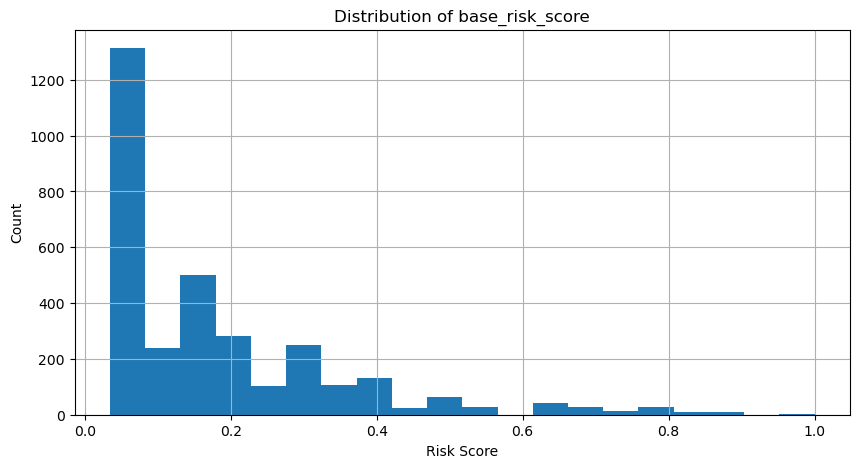

In [71]:
plt.figure(figsize=(10, 5))
df_for_model['base_risk_score'].hist(bins=20)
plt.title('Distribution of base_risk_score')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [72]:
df_for_model['base_risk_score'].describe()


count    3174.000000
mean        0.180906
std         0.164228
min         0.034500
25%         0.069000
50%         0.137900
75%         0.241400
max         1.000000
Name: base_risk_score, dtype: float64


---

#### 🔍 Explanation of Each Metric:

| Metric  | Meaning                           | Interpretation                                                                                |
| ------- | --------------------------------- | --------------------------------------------------------------------------------------------- |
| `count` | Number of valid (non-null) scores | We have 3,174 intersections with a calculated risk score.                                     |
| `mean`  | Average normalized score          | The average risk score is \~0.18 (on a normalized scale between 0 and 1).                     |
| `std`   | Standard deviation                | A value of \~0.16 suggests moderate variability in intersection risk levels.                  |
| `min`   | Minimum risk score                | The lowest score is \~0.034 — very low weighted accident severity.                            |
| `25%`   | First quartile (Q1)               | 25% of intersections have a score below \~0.069 — indicating lower-risk intersections.        |
| `50%`   | Median (Q2)                       | Half of the intersections score below \~0.138 — less sensitive to outliers than the mean.     |
| `75%`   | Third quartile (Q3)               | 75% of intersections score below \~0.241 — meaning most are in the lower-moderate risk range. |
| `max`   | Maximum risk score                | A score of 1.0 indicates the most dangerous intersection in the dataset.                      |


---


***Quantile Thresholds Used:***

In [73]:
# Define threshold: top 25% = high risk
high_risk_threshold = df_for_model['base_risk_score'].quantile(0.75)

# Create binary risk label
def classify_binary_risk(score):
    if score >= high_risk_threshold:
        return 1  # High risk
    else:
        return 0  # Not high risk

df_for_model['risk_level'] = df_for_model['base_risk_score'].apply(classify_binary_risk)

print("High risk threshold:", high_risk_threshold)
df_for_model['risk_level'].value_counts(normalize=True)



High risk threshold: 0.2414


risk_level
0    0.73661
1    0.26339
Name: proportion, dtype: float64

In [74]:
# טבלה של ערך ממוצע ואחוזון 75 של base_risk_score
summary_data = pd.DataFrame({
    'Quantile': ['75th percentile', 'Mean'],
    'base_risk_score': [0.241400, 0.180906]
})
summary_data


,Quantile,base_risk_score
0,75th percentile,0.241400
1,Mean,0.180906


In [75]:
#df_for_model.to_csv('data/df_for_model.csv', index=False)

## A.4.3 - 📘 Data Dictionary – Final Processed Dataset (`df_for_model`)

Short Version:

| Column Name             | Description                                                                 | Type               | Notes / Values |
|-------------------------|-----------------------------------------------------------------------------|--------------------|----------------|
| ZOMET_IRONI             | Intersection ID                                                            | Categorical (int)  | Unique code per intersection |
| SEMEL_YISHUV            | Town code                                                                  | Categorical (int)  | Local authority code |
| X, Y                    | GPS coordinates of the intersection                                         | Float              | Location projection |
| pk_teuna_fikt           | Accident record ID                                                         | Identifier         | Unique ID |
| SHNAT_TEUNA             | Year of the accident                                                       | Integer            | All 2023 |
| HODESH_TEUNA_sin/cos    | Month (cyclic encoded)                                                     | Float              | Used for seasonality |
| YOM_BASHAVUA_sin/cos    | Day of week (cyclic encoded)                                               | Float              | 1=Sun to 7=Sat |
| hour_sin/hour_cos       | Hour of accident (cyclic encoded)                                          | Float              | 0-23 mapped into sin/cos |
| RAMZOR                  | Traffic light presence at the junction                                     | Binary             | 1 = Yes, 0 = No |
| is_night                | Indicator if the accident occurred at night                                | Binary             | 1 = Night, 0 = Day |
| SUG_YOM_*               | One-hot encoding of type of day                                            | Binary             | Holiday, Weekday, Eve, Chol Hamoed |
| MEHIRUT_MUTERET         | Speed limit category                                                       | Ordinal category   | 1=50km/h, ..., 7=110km/h |
| ROHAV                   | Road width                                                                 | Ordinal category   | 1–5 |
| _MultiLaneOneWay        | Road type: multilane one-way                                               | Binary             | 0/1 |
| _SingleLaneOneWay       | Road type: single-lane one-way                                             | Binary             | 0/1 |
| _TwoWay_Separated       | Road type: two-way with separator                                          | Binary             | 0/1 |
| _TwoWay_Unseparated     | Road type: two-way without separator                                       | Binary             | 0/1 |
| is_bad_road             | Road condition not good (shoulder or surface issues)                       | Binary             | 1 = Bad |
| is_signage_problem      | Sign or marking missing or damaged                                         | Binary             | 1 = Problem |
| is_not_clear_weather    | Non-clear weather (rain, fog, etc.)                                        | Binary             | 1 = Not clear |
| is_slippery_road        | Road surface not dry                                                       | Binary             | 1 = Slippery |
| SEX                     | Gender of driver                                                           | Binary             | 0 = Male, 1 = Female |
| vehicle_0               | Private or taxi vehicle                                                    | Binary             | 1 = Yes |
| vehicle_1               | Two-wheeled vehicle                                                        | Binary             | 1 = Yes |
| vehicle_2               | Heavy or other vehicle                                                     | Binary             | 1 = Yes |
| veteran_driver_years    | Years of experience of the driver                                          | Integer            | 1–70 |
| KVUZA_GIL               | Age group of the driver                                                    | Ordinal category   | Grouped from 0–85+ |
| base_risk_score         | Original continuous risk score                                             | Float              | 0.0-1.0 |
| risk_level              | Final target variable (Low, Medium, High risk)                             | Categorical (int)  | 0 = Low, 1 = High |

Full Version:


### 🧩 General Info
| Column Name      | Description                                      | Type               | Notes / Values |
|------------------|--------------------------------------------------|--------------------|----------------|
| ZOMET_IRONI      | Intersection ID                                  | Categorical (int)  | Unique ID |
| SEMEL_YISHUV     | Town code (CBS locality)                         | Categorical (int)  | Israeli municipality code |
| X, Y             | GPS coordinates                                  | Float              | Projected location |
| pk_teuna_fikt    | Unique accident identifier                       | Integer            | Primary accident key |
| SHNAT_TEUNA      | Year of the accident                             | Integer            | All = 2023 |

### 📆 Time Features
| Column Name          | Description                                   | Type               | Notes / Values |
|----------------------|-----------------------------------------------|--------------------|----------------|
| HODESH_TEUNA_sin/cos | Month of accident (cyclical)                  | Float              | From original 1–12 |
| YOM_BASHAVUA_sin/cos | Day of week (cyclical)                        | Float              | 1 = Sunday, ..., 7 = Saturday |
| hour_sin/hour_cos    | Hour of day (cyclical)                        | Float              | 0–23 mapped to sin/cos |
| is_night             | Night accident indicator                      | Binary             | 1 = Night, 0 = Day |

### 🗓️ One-Hot Encoded: Type of Day (`SUG_YOM`)
| Column Name            | Description                      | Type       | Values |
|------------------------|----------------------------------|------------|--------|
| SUG_YOM_Weekday        | Regular weekday                  | One-hot    | 1 = Yes, 0 = No |
| SUG_YOM_HolidayEve     | Eve of holiday                   | One-hot    | 1 = Yes, 0 = No |
| SUG_YOM_Holiday        | Official holiday                 | One-hot    | 1 = Yes, 0 = No |
| SUG_YOM_Intermediate   | Chol Hamoed                      | One-hot    | 1 = Yes, 0 = No |

### 🚥 Road Conditions
| Column Name           | Description                                 | Type               | Notes / Values |
|------------------------|---------------------------------------------|--------------------|----------------|
| RAMZOR                 | Traffic light at intersection               | Binary             | 1 = Yes, 0 = No |
| MEHIRUT_MUTERET        | Speed limit category                        | Ordinal            | 1=≤50, 2=≤60, 3=≤70, 4=≤80, 5=≤90, 6=≤100, 7=≤110 |
| ROHAV                  | Road width                                  | Ordinal            | 1 = ≤5m, 2 = 5–7m, 3 = 7–10.5m, 4 = 10.5–14m, 5 = >14m |

### 🛣️ One-Hot Encoded: Road Type (`HAD_MASLUL`)
| Column Name              | Description                              | Type     | Values |
|--------------------------|------------------------------------------|----------|--------|
| _MultiLaneOneWay         | Multi-lane one-way                       | One-hot  | 1 = Yes, 0 = No |
| _SingleLaneOneWay        | Single-lane one-way                      | One-hot  | 1 = Yes, 0 = No |
| _TwoWay_Separated        | Two-way with separator                   | One-hot  | 1 = Yes, 0 = No |
| _TwoWay_Unseparated      | Two-way without separator                | One-hot  | 1 = Yes, 0 = No |

### 🚗 One-Hot Encoded: Vehicle Type (`vehicle_category`)
| Column Name   | Description                    | Type     | Vehicle Codes |
|---------------|--------------------------------|----------|----------------|
| vehicle_0     | Private or taxi                | One-hot  | 1 = private car, 12 = taxi |
| vehicle_1     | Two-wheeled vehicle            | One-hot  | 8 = light motorcycle, 9 = heavy motorcycle, 10 = very heavy, 15 = bicycle, 19 = extra heavy motorcycle, 21 = e-scooter, 22 = motorized wheelchair, 23 = electric bicycle |
| vehicle_2     | Heavy/Other vehicle            | One-hot  | 2, 3, 5–7 = trucks, 11 = bus, 13 = work vehicle, 14 = tractor, 16 = train, 17 = other, 18 = small bus, 24–25 = other trucks |

### ⚠️ Risk & Road Flags
| Column Name           | Description                         | Type   | Values |
|------------------------|-------------------------------------|--------|--------|
| is_bad_road            | Poor shoulder or road               | Binary | 1 = Problem, 0 = OK |
| is_signage_problem     | Sign/marking missing/damaged        | Binary | 1 = Problem, 0 = OK |
| is_not_clear_weather   | Weather is not clear                | Binary | 1 = Not clear, 0 = Clear |
| is_slippery_road       | Surface not dry                     | Binary | 1 = Slippery, 0 = Dry |

### 👤 Driver Info
| Column Name           | Description                             | Type               | Notes / Values |
|------------------------|-----------------------------------------|--------------------|----------------|
| SEX                    | Gender                                  | Binary             | 0 = Male, 1 = Female |
| veteran_driver_years   | Driving experience (years)              | Integer            | Range: 1–70 |
| KVUZA_GIL              | Age group                               | Ordinal            || 1         | 0–4         |
| 2         | 5–9         |
| 3         | 10–14       |
| 4         | 15–19       |
| 5         | 20–24       |
| 6         | 25–29       |
| 7         | 30–34       |
| 8         | 35–39       |
| 9         | 40–44       |
| 10        | 45–49       |
| 11        | 50–54       |
| 12        | 55–59       |
| 13        | 60–64       |
| 14        | 65–69       |
| 15        | 70–74       |
| 16        | 75–79       |
| 17        | 80–84       |
| 18        | 85+         |

### 🎯 Target Variables
| Column Name      | Description                        | Type               | Notes / Values |
|------------------|------------------------------------|--------------------|----------------|
| base_risk_score  | Raw continuous risk score          | Float              | Min = 0.0, Max = 1.0 |
| risk_level       | Final target class                 | Categorical (int)  | 0 = Low, 1 = High |


In [76]:
print(df_for_model.dtypes)

ZOMET_IRONI                    float64
SEMEL_YISHUV                     int64
X                              float64
Y                              float64
pk_teuna_fikt                    int64
SHNAT_TEUNA                      int64
HODESH_TEUNA                     int64
YOM_BASHAVUA                     int64
MEHIRUT_MUTERET                  int64
ROHAV                            int64
RAMZOR                           int64
KVUZA_GIL                        int64
base_risk_score                float64
veteran_driver_years           float64
HOUR                             int64
HODESH_TEUNA_sin               float64
HODESH_TEUNA_cos               float64
SUG_YOM_Holiday                  int64
SUG_YOM_HolidayEve               int64
SUG_YOM_IntermediateHoliday      int64
SUG_YOM_Weekday                  int64
is_night                         int64
YOM_BASHAVUA_sin               float64
YOM_BASHAVUA_cos               float64
_MultiLaneOneWay                 int64
_SingleLaneOneWay        

## A.5 - Modelling

### Class Balance Check: `risk_level`

Before training the model, we evaluated the class distribution of our target variable `risk_level` (Low, Medium, High risk) to ensure it is not heavily imbalanced.

 **Why this is important:**
- Imbalanced classes can lead to models that are **biased toward the majority class**
- A model may achieve high accuracy but **perform poorly** on underrepresented categories
- We may need to apply techniques like **SMOTE**, **undersampling**, or **class weights** if imbalance is significant


In [77]:
df_for_model['risk_level'].value_counts(normalize=True)


risk_level
0    0.73661
1    0.26339
Name: proportion, dtype: float64

### Dropping Unnecessary Columns Before Model Training - Creating `df_final`

Before training the model, we removed columns that are not useful for learning patterns. These include:

- **Identifiers**:
  - `ZOMET_IRONI`, `pk_teuna_fikt`, `SEMEL_YISHUV` → purely identifying info
- **Geographic Coordinates**:
  - `X`, `Y` → raw coordinates not yet used as features (can be reintroduced later with spatial encoding)
- **Constant or Redundant Info**:
  - `SHNAT_TEUNA` → all accidents occurred in 2023 (no variation)
  - `base_risk_score` → replaced by `risk_level` classification target
- **Raw Temporal Columns**:
  - `HODESH_TEUNA`, `YOM_BASHAVUA`, `HOUR` → replaced by their cyclical sin/cos counterparts

This cleaning step ensures that the dataset used for training (`df_final`) contains only relevant and preprocessed features.

In [78]:
# Define columns to drop before training
columns_to_drop = [
    'ZOMET_IRONI',          # Intersection ID – identifier only
    'SEMEL_YISHUV',         # Town code – not encoded spatially
    'X', 'Y',               # GPS coordinates – not transformed into features
    'pk_teuna_fikt',        # Accident ID – just an identifier
    'SHNAT_TEUNA',          # All values are 2023 – no variance
    'HODESH_TEUNA',         # Replaced by HODESH_TEUNA_sin/cos
    'YOM_BASHAVUA',         # Replaced by YOM_BASHAVUA_sin/cos
    'HOUR',                 # Replaced by hour_sin/hour_cos
    'base_risk_score'       # Replaced by risk_level (final target)
]

# Create a new cleaned DataFrame
df_final = df_for_model.drop(columns=columns_to_drop)

# Save the cleaned version for modeling
#df_final.to_csv('data_model/df_final.csv', index=False)
df_final

,MEHIRUT_MUTERET,ROHAV,RAMZOR,KVUZA_GIL,veteran_driver_years,HODESH_TEUNA_sin,HODESH_TEUNA_cos,SUG_YOM_Holiday,SUG_YOM_HolidayEve,SUG_YOM_IntermediateHoliday,...,is_signage_problem,is_not_clear_weather,is_slippery_road,SEX,vehicle_0,vehicle_1,vehicle_2,hour_sin,hour_cos,risk_level
0,1,3,1,10,8.0,0.500000,8.660254e-01,0,0,0,...,0,0,0,1,1,0,0,0.707107,-7.071068e-01,0
1,1,3,1,7,8.0,0.500000,8.660254e-01,0,0,0,...,0,0,0,0,0,1,0,0.707107,-7.071068e-01,0
2,1,2,0,9,25.0,1.000000,6.123234e-17,0,0,0,...,0,0,0,0,0,0,1,-0.258819,-9.659258e-01,0
3,1,2,0,5,3.0,0.500000,-8.660254e-01,0,0,0,...,0,0,0,0,1,0,0,-1.000000,-1.836970e-16,0
4,1,3,0,8,5.0,-1.000000,-1.836970e-16,0,0,0,...,0,0,0,1,1,0,0,-0.258819,-9.659258e-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4612,1,2,1,10,33.0,0.866025,-5.000000e-01,0,0,0,...,0,0,0,0,0,1,0,-0.258819,-9.659258e-01,0
4613,1,2,1,8,19.0,-0.500000,-8.660254e-01,0,0,0,...,0,0,0,0,1,0,0,-0.707107,-7.071068e-01,0
4614,1,2,1,13,47.0,-0.500000,-8.660254e-01,0,0,0,...,0,0,0,1,1,0,0,-0.707107,-7.071068e-01,0
4615,1,2,1,5,7.0,1.000000,6.123234e-17,0,0,0,...,0,1,0,1,0,1,0,0.866025,-5.000000e-01,0


### EDA

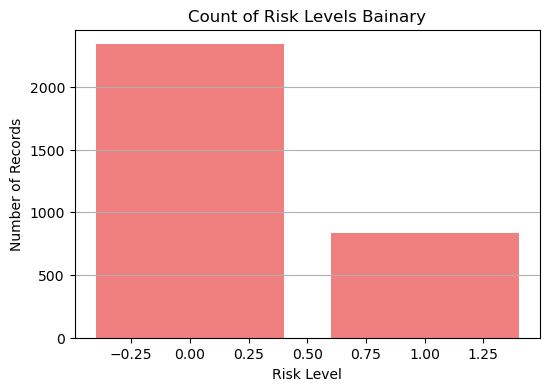

In [79]:
# Count how many records there are for each risk level
risk_counts = df_final['risk_level'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(risk_counts.index, risk_counts.values, color='lightcoral')
plt.title('Count of Risk Levels Bainary')
plt.xlabel('Risk Level')
plt.ylabel('Number of Records')
plt.grid(axis='y')
plt.show()

# Explanation:
# This plot shows how many samples there are for each risk level (0 = low, 1 = medium, 2 = high).
# It's important to see if the classes are balanced before training a model.

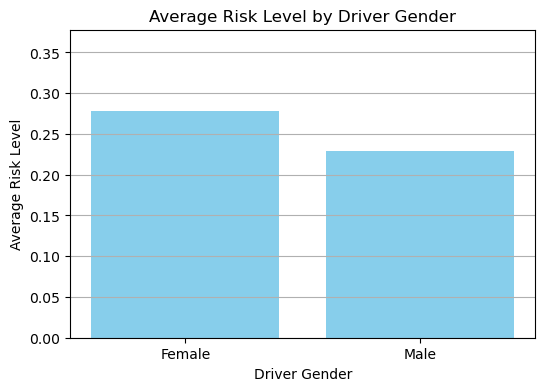

In [80]:
# Calculate the average risk level for each gender (0 = female, 1 = male)
avg_risk_by_gender = df_final.groupby('SEX')['risk_level'].mean()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Female', 'Male'], avg_risk_by_gender.values, color='skyblue')
plt.title('Average Risk Level by Driver Gender')
plt.xlabel('Driver Gender')
plt.ylabel('Average Risk Level')
plt.ylim(0, max(avg_risk_by_gender.values) + 0.1)
plt.grid(axis='y')
plt.show()

# Explanation:
# This bar chart shows the average risk level of accidents involving male vs. female drivers.
# It helps us explore if one gender is more associated with higher-risk events.

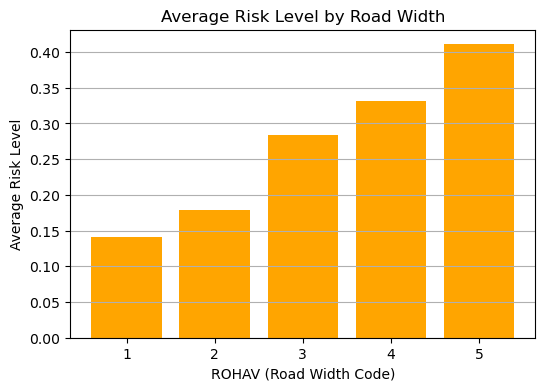

In [81]:
# Group by ROHAV (road width code) and calculate average risk level
avg_risk_by_rohav = df_final.groupby('ROHAV')['risk_level'].mean()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(avg_risk_by_rohav.index, avg_risk_by_rohav.values, color='orange')
plt.title('Average Risk Level by Road Width')
plt.xlabel('ROHAV (Road Width Code)')
plt.ylabel('Average Risk Level')
plt.grid(axis='y')
plt.show()

# Explanation:
# This plot shows the average risk level for each road width category.
# It helps us understand whether narrow or wide roads tend to be riskier.

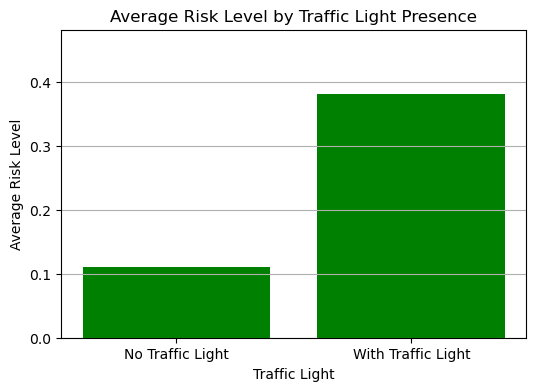

In [82]:
# Group by RAMZOR and calculate average risk level
avg_risk_by_ramzor = df_final.groupby('RAMZOR')['risk_level'].mean()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['No Traffic Light', 'With Traffic Light'], avg_risk_by_ramzor.values, color='green')
plt.title('Average Risk Level by Traffic Light Presence')
plt.xlabel('Traffic Light')
plt.ylabel('Average Risk Level')
plt.ylim(0, max(avg_risk_by_ramzor.values) + 0.1)
plt.grid(axis='y')
plt.show()

# Explanation:
# This bar chart compares the average risk level between intersections
# with and without traffic lights in the cleaned df_final dataset.
# We first removed all rows where RAMZOR == 9 (unknown) to ensure clean binary values.

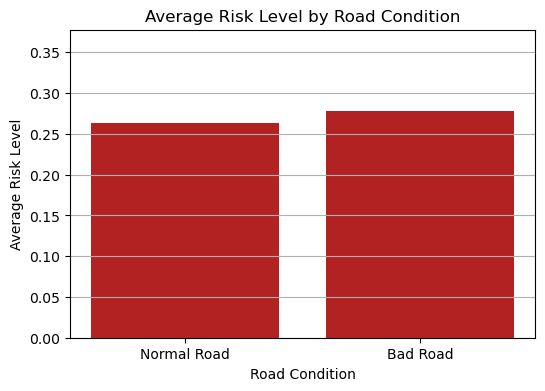

In [83]:
# Group by road condition (0 = normal road, 1 = bad road)
avg_risk_by_road = df_final.groupby('is_bad_road')['risk_level'].mean()

# Labels
labels = ['Normal Road', 'Bad Road']

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, avg_risk_by_road.values, color='firebrick')
plt.title('Average Risk Level by Road Condition')
plt.xlabel('Road Condition')
plt.ylabel('Average Risk Level')
plt.ylim(0, max(avg_risk_by_road.values) + 0.1)
plt.grid(axis='y')
plt.show()

# Explanation:
# This plot shows whether intersections on poorly maintained roads tend to be more dangerous,
# based on the average risk level calculated from the cleaned dataset.

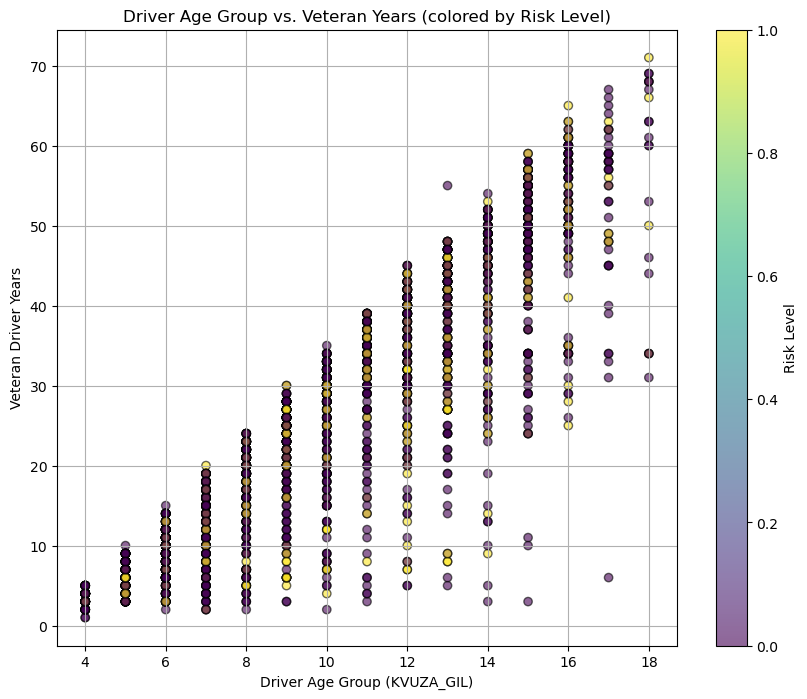

In [84]:
# Scatter plot: Age Group vs Veteran Years, colored by risk level
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_final['KVUZA_GIL'],
    df_final['veteran_driver_years'],
    c=df_final['risk_level'],
    cmap='viridis',  # צבעים שונים לפי רמת סיכון
    alpha=0.6,
    edgecolor='k'
)

plt.title('Driver Age Group vs. Veteran Years (colored by Risk Level)')
plt.xlabel('Driver Age Group (KVUZA_GIL)')
plt.ylabel('Veteran Driver Years')
cbar = plt.colorbar(scatter)
cbar.set_label('Risk Level')
plt.grid(True)
plt.show()

# Explanation:
# Each dot represents an intersection (or accident).
# X-axis: driver age group.
# Y-axis: years of driving experience.
# Color: the risk level — helps us see clusters of risk across age and experience.

### Correlation Analysis

Before training the model, we generated a correlation matrix to explore relationships between numerical features.

#### Why this matters:
- Helps identify **redundant features** with very high correlation (multicollinearity)
- May reveal **unexpected relationships** or data leakage
- Useful for **feature selection** and model explainability

#### What we used:
We used `df_final.corr()` to calculate pairwise correlations between features, and visualized it using `seaborn.heatmap()`.

#### How to read it:
- **+1.00** → Strong positive linear relationship
- **-1.00** → Strong negative linear relationship
- **0.00** → No linear relationship
- Diagonal will always show 1.00 (self-correlation)

> We look for any clusters or strong relationships that might affect model performance or suggest feature engineering opportunities.

In [85]:
df_final.corr() # comapre between all the columns:

,MEHIRUT_MUTERET,ROHAV,RAMZOR,KVUZA_GIL,veteran_driver_years,HODESH_TEUNA_sin,HODESH_TEUNA_cos,SUG_YOM_Holiday,SUG_YOM_HolidayEve,SUG_YOM_IntermediateHoliday,...,is_signage_problem,is_not_clear_weather,is_slippery_road,SEX,vehicle_0,vehicle_1,vehicle_2,hour_sin,hour_cos,risk_level
MEHIRUT_MUTERET,1.000000,0.243880,0.215822,-0.015352,-0.013543,-0.008764,-0.032731,-0.025086,0.012893,0.008482,...,-0.030874,0.012350,-0.024458,-0.003929,0.063064,-0.059955,-0.022800,-0.010785,0.039716,0.150062
ROHAV,0.243880,1.000000,0.333544,-0.028623,-0.033867,0.002141,0.009060,0.002423,0.002664,0.005951,...,-0.054672,0.022389,0.037803,-0.021107,0.034545,-0.021086,-0.024577,-0.037691,0.052051,0.179047
RAMZOR,0.215822,0.333544,1.000000,-0.027663,-0.023800,-0.002169,0.014698,0.006220,-0.032975,0.022850,...,-0.108125,0.011424,0.013805,-0.049481,-0.020570,0.008469,0.018836,0.003295,0.094474,0.305493
KVUZA_GIL,-0.015352,-0.028623,-0.027663,1.000000,0.905379,-0.024556,0.015515,-0.027270,0.011836,-0.000737,...,-0.025298,-0.024569,-0.002160,-0.008006,0.098143,-0.172020,0.045446,0.118704,-0.244247,-0.001192
veteran_driver_years,-0.013543,-0.033867,-0.023800,0.905379,1.000000,-0.027482,0.020495,-0.026690,0.008015,-0.009646,...,-0.022304,-0.012372,0.005979,-0.075986,0.058667,-0.145254,0.070785,0.114146,-0.235852,0.008783
HODESH_TEUNA_sin,-0.008764,0.002141,-0.002169,-0.024556,-0.027482,1.000000,0.040373,0.044301,-0.006999,-0.026957,...,0.046162,0.132061,0.121268,-0.006758,-0.001934,0.019350,-0.017304,0.004715,0.064298,-0.043456
HODESH_TEUNA_cos,-0.032731,0.009060,0.014698,0.015515,0.020495,0.040373,1.000000,-0.059400,-0.042722,0.014215,...,0.000651,0.114975,0.158541,-0.012217,-0.018260,0.029210,-0.005582,-0.006579,-0.034241,0.006769
SUG_YOM_Holiday,-0.025086,0.002423,0.006220,-0.027270,-0.026690,0.044301,-0.059400,1.000000,-0.018570,-0.016735,...,0.030084,-0.024502,-0.024206,-0.006881,-0.012704,0.006939,0.009877,-0.048894,0.072303,-0.009722
SUG_YOM_HolidayEve,0.012893,0.002664,-0.032975,0.011836,0.008015,-0.006999,-0.042722,-0.018570,1.000000,-0.022108,...,0.049048,-0.011571,-0.031977,0.014638,0.021188,-0.012360,-0.015663,0.003587,-0.024296,-0.037513
SUG_YOM_IntermediateHoliday,0.008482,0.005951,0.022850,-0.000737,-0.009646,-0.026957,0.014215,-0.016735,-0.022108,1.000000,...,-0.017305,-0.029169,-0.028817,-0.012712,0.016951,-0.023230,0.001186,-0.007326,0.032399,0.024136


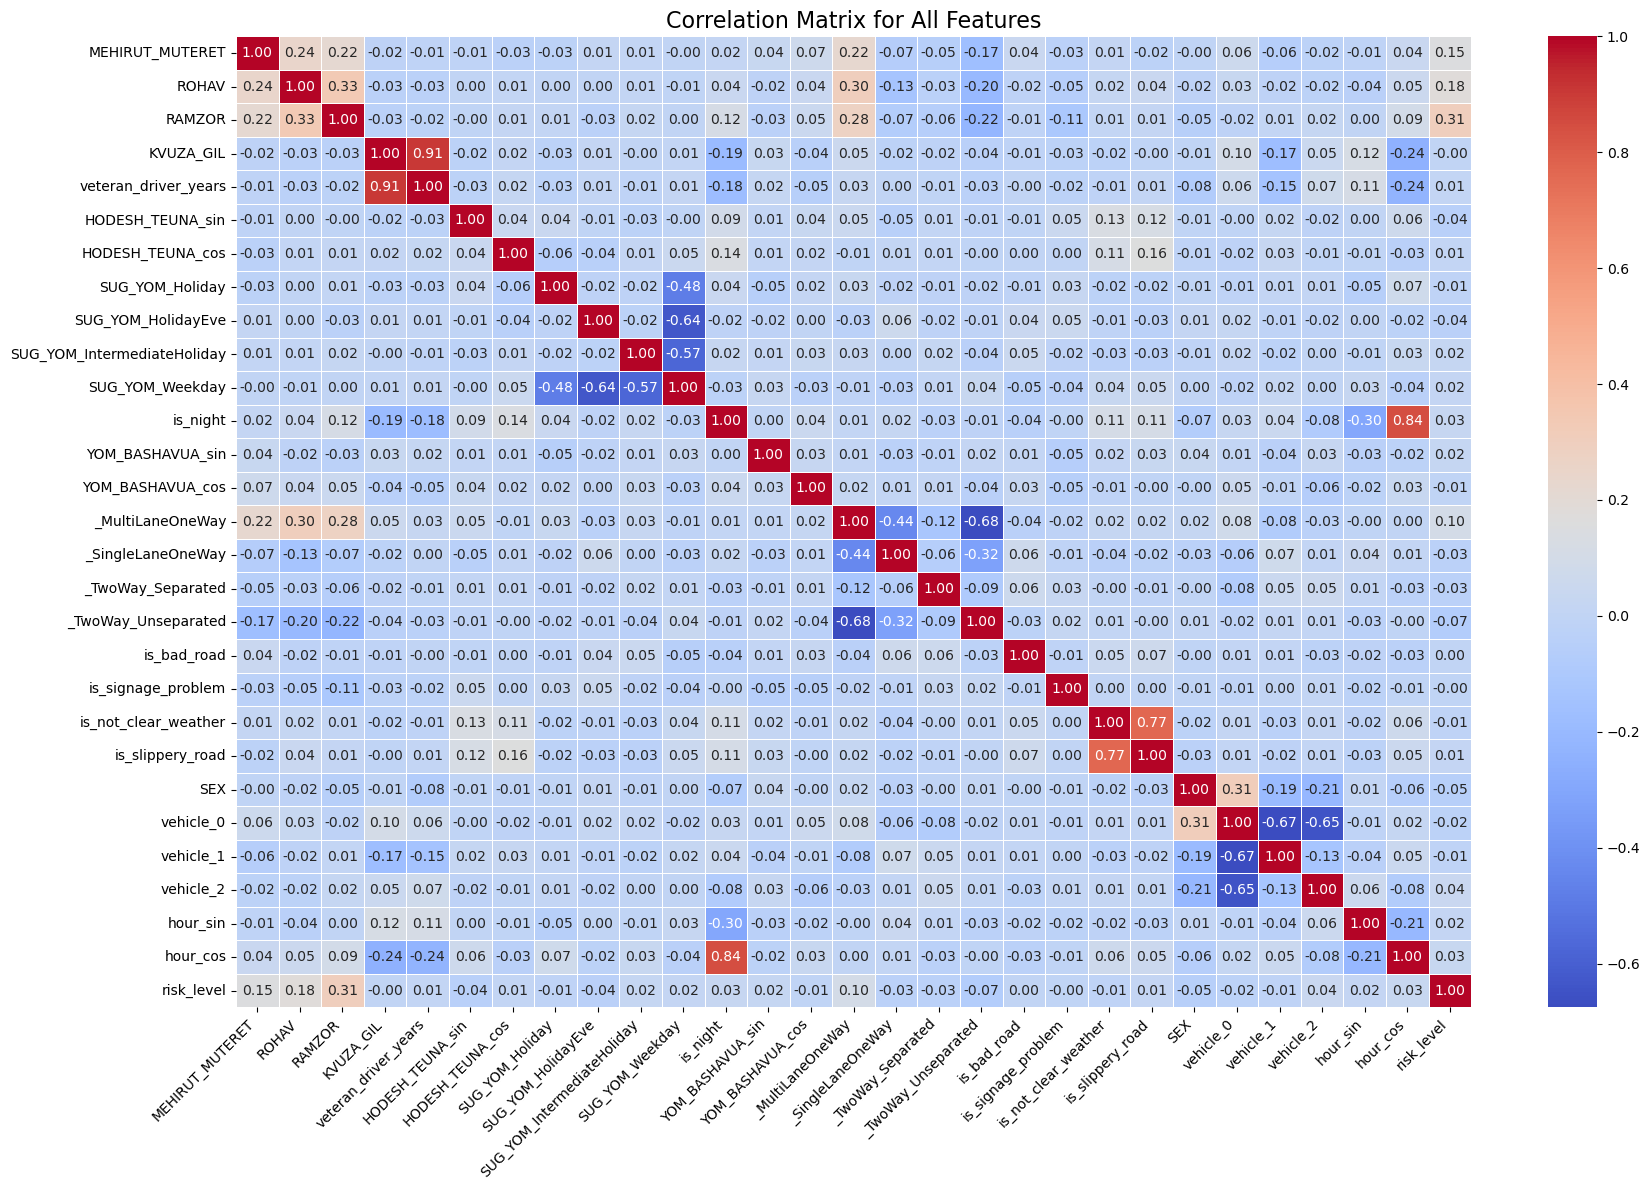

In [86]:

# Set the figure size for better readability
plt.figure(figsize=(18, 12))

# Create the heatmap
sns.heatmap(df_final.corr(),      # Calculate correlation matrix
            annot=True,           # Show correlation values
            fmt=".2f",            # Format to 2 decimal places
            cmap="coolwarm",      # Use a diverging color scale
            linewidths=0.5)       # Add lines between squares

# Set title and axis styling
plt.title("Correlation Matrix for All Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig("correlation_heatmap.png", dpi=300)  # Saves as image
plt.show()

### Prepering our data for ML model:

In [87]:
# TOOLS:

# Model Evaluation tools from Scikit-Learn
from sklearn.model_selection import train_test_split  # Splits data into training and testing sets
from sklearn.model_selection import cross_val_score  # Performs cross-validation to evaluate model performance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV  # Hyperparameter tuning methods
# RandomizedSearchCV - Random search over a parameter grid
# GridSearchCV - Exhaustive search over a parameter grid

# Model Evaluation metrics from Scikit-Learn
from sklearn.metrics import confusion_matrix  # Creates a confusion matrix to evaluate classification
from sklearn.metrics import classification_report  # Provides a summary of precision, recall, f1-score, and support
from sklearn.metrics import precision_score, recall_score, f1_score  # Metrics to evaluate model's performance
from sklearn.metrics import RocCurveDisplay # new in Scikit-Learn 1.2+  # Plots ROC curve for binary classification model

###  Train-Test Split Summary

We split our data into **80% training** and **20% testing** using Scikit-Learn's `train_test_split()`.

- `X_train`: (2539, 28) → 2,539 training samples, each with **28 features**
- `Y_train`: (2539,) → 2,539 target labels
- `X_test`: (635, 28) → 635 testing samples, each with 28 features
- `Y_test`: (635,) → 635 target labels


***Why use `stratify=Y`?***

Setting `stratify=Y` ensures that the **distribution of target classes (risk levels)** remains consistent between training and testing sets.

This is especially important in **classification tasks** to avoid bias and ensure each class is properly represented during both training and evaluation.

In [88]:
# Split data into X and y
# X & Y Cappital Latter!
df_final = df_final.reset_index(drop=True)# clear the rows

X = df_final.drop("risk_level", axis=1) # evrithing but target col

Y = df_final["risk_level"] # only target col

In [89]:
X

,MEHIRUT_MUTERET,ROHAV,RAMZOR,KVUZA_GIL,veteran_driver_years,HODESH_TEUNA_sin,HODESH_TEUNA_cos,SUG_YOM_Holiday,SUG_YOM_HolidayEve,SUG_YOM_IntermediateHoliday,...,is_bad_road,is_signage_problem,is_not_clear_weather,is_slippery_road,SEX,vehicle_0,vehicle_1,vehicle_2,hour_sin,hour_cos
0,1,3,1,10,8.0,0.500000,8.660254e-01,0,0,0,...,0,0,0,0,1,1,0,0,0.707107,-7.071068e-01
1,1,3,1,7,8.0,0.500000,8.660254e-01,0,0,0,...,0,0,0,0,0,0,1,0,0.707107,-7.071068e-01
2,1,2,0,9,25.0,1.000000,6.123234e-17,0,0,0,...,0,0,0,0,0,0,0,1,-0.258819,-9.659258e-01
3,1,2,0,5,3.0,0.500000,-8.660254e-01,0,0,0,...,0,0,0,0,0,1,0,0,-1.000000,-1.836970e-16
4,1,3,0,8,5.0,-1.000000,-1.836970e-16,0,0,0,...,0,0,0,0,1,1,0,0,-0.258819,-9.659258e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1,2,1,10,33.0,0.866025,-5.000000e-01,0,0,0,...,0,0,0,0,0,0,1,0,-0.258819,-9.659258e-01
3170,1,2,1,8,19.0,-0.500000,-8.660254e-01,0,0,0,...,0,0,0,0,0,1,0,0,-0.707107,-7.071068e-01
3171,1,2,1,13,47.0,-0.500000,-8.660254e-01,0,0,0,...,0,0,0,0,1,1,0,0,-0.707107,-7.071068e-01
3172,1,2,1,5,7.0,1.000000,6.123234e-17,0,0,0,...,0,0,1,0,1,0,1,0,0.866025,-5.000000e-01


In [90]:
Y

0       0
1       0
2       0
3       0
4       0
       ..
3169    0
3170    0
3171    0
3172    0
3173    0
Name: risk_level, Length: 3174, dtype: int64

In [91]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    stratify=Y,     # 🔍 Ensure class distribution stays consistent in train and test
    random_state=42 # Reproducible split
)

# Optional: check the shapes
print("Train:", X_train.shape, Y_train.shape)
print("Test :", X_test.shape, Y_test.shape)

Train: (2539, 28) (2539,)
Test : (635, 28) (635,)


## A.5.1 - Chossing the right Model:

****Model Evaluation Summary – Risk Prediction Project****

Objective:
Predict whether an intersection is **high-risk** or **not high-risk** based on accident severity data.

---

***Initial Approach*** – Multiclass Classification

- **Labeling:** We divided intersections into 3 classes using quantiles of `base_risk_score`:
  - 0 = Low risk (≤ 33rd percentile)
  - 1 = Medium risk (33–66 percentile)
  - 2 = High risk (> 66th percentile)

- **Models Tested:**
  | Model                | Accuracy |
  |---------------------|----------|
  | Logistic Regression | 0.463    |
  | K-Nearest Neighbors | 0.406    |
  | SGD Classifier      | 0.357    |
  | Gradient Boosting   | 0.487    |
  | Random Forest       | **0.713**  Best (just this score after RandomizedSearchCV and gread the inital score was 0.66!!)

- **Improvements Tried:**
  - Scaling for sensitive models (LogReg, KNN, SGD) → ❌ No major impact
  - Hyperparameter tuning for Random Forest and XGBoost → ✅ Slight improvements
  - Trying XGBoost (tuned) → 0.645 accuracy → ❌ did not beat Random Forest

---

****Key Breakthrough – Binary Classification****

- **New Strategy:** Redefined `risk_level` to:
  - `1` = High risk → top 25% of `base_risk_score`
  - `0` = Not high risk → bottom 75%

- **Why?**
  - Reduced class confusion (no more ambiguous "medium")
  - Focused model on identifying truly dangerous intersections


    - **'Random Forest': 0.8299212598425196** Before RandomizeSearchCV

- **Best Model (Random Forest):**
  ```python
  n_estimators = 105
  max_features = 'sqrt'
  bootstrap = False
**Final Test Accuracy: 0.8551 !!**

| Phase             | Accuracy    |
| ----------------- | ----------- |
| Multiclass (best) | 71.3%       |
| Binary (best)     | **85.5%** ✅ |


In [92]:
# TOOLS + FUNC to run the models in a loop
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Put models in a dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SGD Classifier": SGDClassifier()
}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, Y_train, Y_test):
    """
    Fits and evaluates given machine learning models.

    Parameters:
    - models: dict of Scikit-Learn model instances
    - X_train: training features
    - X_test: test features
    - Y_train: training labels
    - Y_test: test labels

    Returns:
    - model_scores: dict containing model names and accuracy on test set
    """
    np.random.seed(42)  # Ensure reproducibility
    model_scores = {}

    for name, model in models.items():
        model.fit(X_train, Y_train)
        score = model.score(X_test, Y_test)
        model_scores[name] = score
    
    return model_scores

# Run the comparison
model_scores = fit_and_score(models, X_train, X_test, Y_train, Y_test)

# View the results
model_scores


{'Logistic Regression': 0.7291338582677165,
 'K-Nearest Neighbors': 0.710236220472441,
 'Random Forest': 0.8299212598425196,
 'Gradient Boosting': 0.7543307086614173,
 'SGD Classifier': 0.7322834645669292}

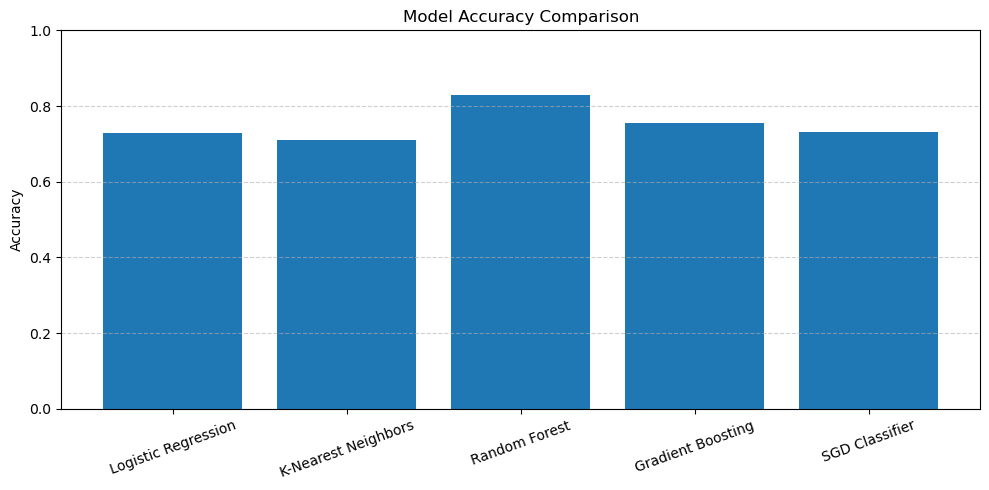

In [93]:
# Model scores
model_scores = {'Logistic Regression': 0.7291338582677165,
 'K-Nearest Neighbors': 0.710236220472441,
 'Random Forest': 0.8299212598425196,
 'Gradient Boosting': 0.7543307086614173,
 'SGD Classifier': 0.7322834645669292}

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(model_scores.keys(), model_scores.values())
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Hyperparameter Tuning with RandomizedSearchCV (random forest)

We now tune our best-performing model — Random Forest — using `RandomizedSearchCV`.

This method tests random combinations of hyperparameters across cross-validation folds to find the best settings efficiently.

Key hyperparameters we explore include:
- `n_estimators` (number of trees)
- `max_depth` (tree depth)
- `min_samples_split`, `min_samples_leaf`
- `max_features`
- `bootstrap` sampling

(0.7134)

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Define the hyperparameter grid
rf_grid = {
    "n_estimators": np.arange(100, 1000, 100),
    "max_depth": [None] + list(np.arange(5, 30, 5)),
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['auto', 'sqrt'],
    "bootstrap": [True, False]
}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_grid,
    n_iter=50,               # Number of combinations to try
    cv=5,                    # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,               # Use all CPU cores
    random_state=42
)

# Fit to training data
rf_random_search.fit(X_train, Y_train)

# Show the best combination
print("Best parameters found:")
print(rf_random_search.best_params_)

# Evaluate on test set
best_rf_model = rf_random_search.best_estimator_
Y_preds = best_rf_model.predict(X_test)
print("Test Accuracy:", accuracy_score(Y_test, Y_preds))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\itama\Desktop\FinalProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\itama\Desktop\FinalProject\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\itama\Desktop\FinalProject\env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\itama\Desktop\FinalProject\env\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_con

Best parameters found:
{'n_estimators': np.int64(100), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Test Accuracy: 0.8535433070866142


In [95]:
# Create the final model with best parameters
final_rf_model = RandomForestClassifier(
    n_estimators=105,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)

# Fit the model on the full training set
final_rf_model.fit(X_train, Y_train)

# Evaluate on test set
final_accuracy = final_rf_model.score(X_test, Y_test)
print(f"Final Random Forest Test Accuracy: {final_accuracy:.4f}")

Final Random Forest Test Accuracy: 0.8551


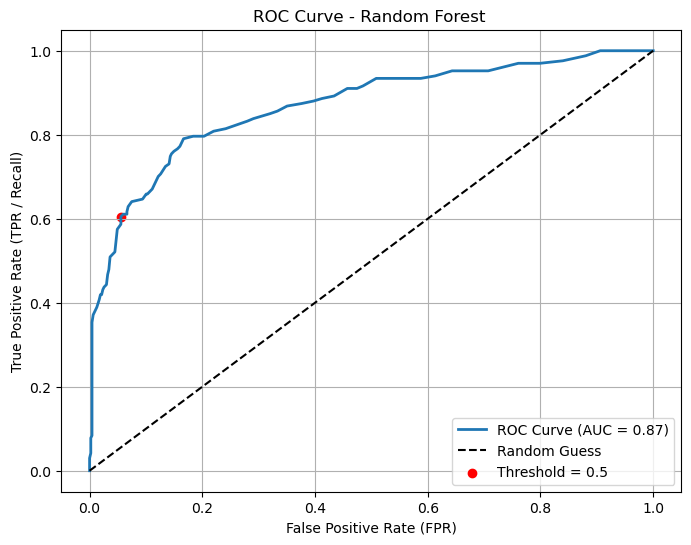

In [96]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get predicted probabilities for class 1 (high risk)
y_scores = final_rf_model.predict_proba(X_test)[:, 1]

# Step 2: Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_scores)

# Step 3: Calculate AUC
auc_score = roc_auc_score(Y_test, y_scores)

# Step 4: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Step 5: Mark custom threshold (0.5)
threshold_index = np.abs(thresholds - 0.5).argmin()
plt.scatter(fpr[threshold_index], tpr[threshold_index], color='red', label='Threshold = 0.5')

# Styling
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curve - Random Forest ')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## A.5.2 - ***Evaluting*** our tuned machine learning classifier, beyond accuracy 
****with our best model yet : *`Random Forest`***** (AND KEEP IMPROVING!)

* `ROC curve and AUC score`
* **Confusion matrix**
* **Classification report:**
* Precision
* Recall
* F1-score


... cross-validation .

* **Feature Importance**

To make comparisons and evaluate our trained model, first we need to make predictions.

### Why We Prioritize `Recall Over Precision`

In this safety-focused project, our top priority is to **identify as many dangerous intersections as possible**, even if it means occasionally flagging a safe one by mistake.

We prefer:
✅ **False alarms (false positives)**  
❌ Over missing real dangers (false negatives)

#### 🧠 Analogy:
> Would you rather:
> - ❌ Miss a dangerous intersection that could cause harm? (**recall failure**)  
> - ❗ Mistakenly flag a safe one as dangerous and review it? (**precision failure**)

Most would agree — in a public safety context — it's better to **err on the side of caution**.

---
> **We prefer false alarms if it means fewer real dangers go undetected.**

In [97]:
from sklearn.metrics import classification_report

Y_pred_original = final_rf_model.predict(X_test)
print("📊 Original Model (no class_weight):")
print(classification_report(Y_test, Y_pred_original))


📊 Original Model (no class_weight):
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       468
           1       0.80      0.60      0.69       167

    accuracy                           0.86       635
   macro avg       0.83      0.77      0.80       635
weighted avg       0.85      0.86      0.85       635



In [98]:
# Confusion matrix
print(confusion_matrix(Y_test, Y_pred_original))

[[442  26]
 [ 66 101]]


`y_preds` contains the predicted labels for the test dataset `(X_test)` using the tuned model, gs_log_reg.

These predictions `(y_preds)` will later be compared to the true labels `(y_test)` to evaluate how well the model is performing on unseen data.

In [99]:
Y_pred_original

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [100]:
Y_test

1442    1
2578    0
1150    0
2823    0
256     0
       ..
1853    0
1313    0
3029    0
833     0
2086    1
Name: risk_level, Length: 635, dtype: int64

### ***`Confusin Matrix & Classifiction Report`*** & Threshold Adjustment for Better Recall 

By default, models predict class `1` (high risk) when the probability is ≥ 0.5.  
We **lowered this threshold to 0.39**, which means:

> "If the model is even 39% confident it's dangerous — raise a flag."

This change:
- ✅ Made the model **less strict**
- ✅ Increased **recall** (caught more true high-risk cases)
- ❌ Slightly decreased **precision** (more false alarms)


After testing different threshold levels, we found that lowering the classification threshold helps the model catch more high-risk cases (improves recall) — but it sometimes comes at the cost of precision and accuracy.

We took this a step further by combining:
- A **lower threshold** of **0.39**
- And using **`class_weight='balanced'`** in the Random Forest model

This gave us the best results overall:

| Metric            | Value |
|-------------------|--------|
| **Recall (class 1)**    | **0.71** ✅  
| **Precision (class 1)** | **0.71** ✅  
| **F1-score (class 1)**  | **0.71** ✅  
| **Accuracy**            | **0.85** ✅  

 **Why this worked:**
- Lowering the threshold made the model **more sensitive** to detecting dangerous cases
- `class_weight='balanced'` helped the model learn better from the minority class (class 1)
- The combination improved **recall without hurting precision**, which is ideal for safety-critical applications

This is our new baseline moving forward.

In [101]:
# Step 1: Train Random Forest with class weighting
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    class_weight='balanced',  # 👈 key change
    random_state=42
)

rf_balanced.fit(X_train, Y_train)

# Step 2: Evaluate
Y_pred_balanced = rf_balanced.predict(X_test)

final_accuracy = rf_balanced.score(X_test, Y_test)
print(final_accuracy)
print("📊 Balanced Model (with class_weight):")
print(classification_report(Y_test, Y_pred_balanced, target_names=["Not High Risk", "High Risk"]))

0.8582677165354331
📊 Balanced Model (with class_weight):
               precision    recall  f1-score   support

Not High Risk       0.86      0.96      0.91       468
    High Risk       0.83      0.58      0.68       167

     accuracy                           0.86       635
    macro avg       0.85      0.77      0.80       635
 weighted avg       0.86      0.86      0.85       635



In [102]:
# Confusion matrix
print(confusion_matrix(Y_test, Y_pred_balanced))

[[448  20]
 [ 70  97]]


In [103]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Step 1: Get predicted probabilities
probs = rf_balanced.predict_proba(X_test)

# Step 2: Apply custom threshold (0.4 instead of default 0.5)
Y_pred_custom = (probs[:, 1] >= 0.39).astype(int)

# Step 3: Evaluate
print("📊 Model with Threshold = 0.39")
print(classification_report(Y_test, Y_pred_custom))
print(confusion_matrix(Y_test, Y_pred_custom))


📊 Model with Threshold = 0.39
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       468
           1       0.71      0.71      0.71       167

    accuracy                           0.85       635
   macro avg       0.80      0.80      0.80       635
weighted avg       0.85      0.85      0.85       635

[[419  49]
 [ 48 119]]


C:\Users\itama\AppData\Local\Temp\ipykernel_21988\1095833249.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\itama\Desktop\FinalProject\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


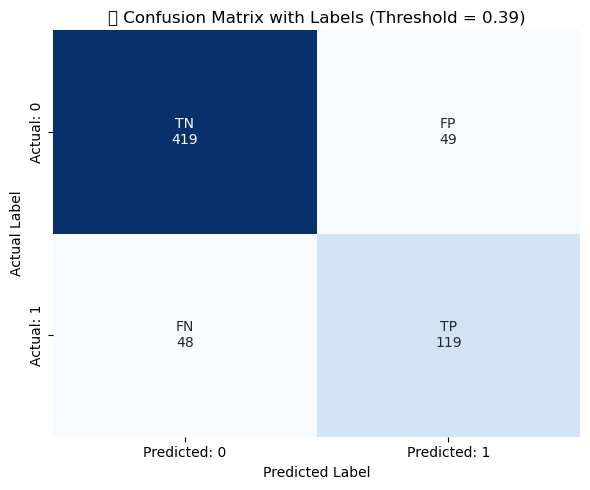

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred_custom)

# Step 2: Create annotated labels
labels = [["TN", "FP"], ["FN", "TP"]]
annot = [[f"{labels[i][j]}\n{cm[i][j]}" for j in range(2)] for i in range(2)]

# Step 3: Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False,
            xticklabels=["Predicted: 0", "Predicted: 1"],
            yticklabels=["Actual: 0", "Actual: 1"])
plt.title("📊 Confusion Matrix with Labels (Threshold = 0.39)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


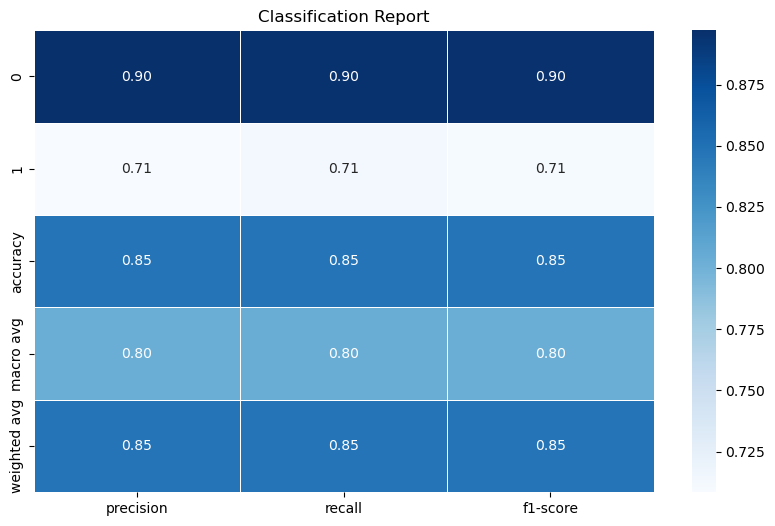

In [105]:
# Generate classification report as dictionary
report = classification_report(Y_test, Y_pred_custom, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude the 'accuracy' row if not needed

# Plot heatmap with appropriate settings
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='Blues', fmt=".2f", cbar=True, linewidths=0.5)
plt.title("Classification Report")
plt.show()

### ***`ROC CURVE`***

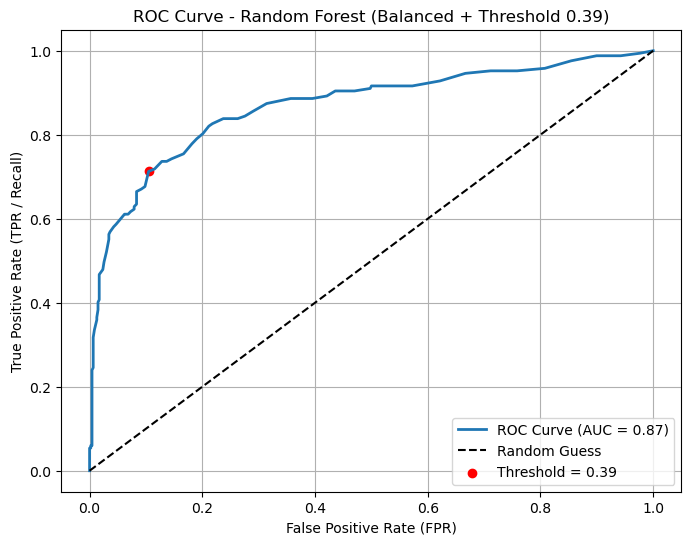

In [106]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get predicted probabilities for class 1 (high risk)
y_scores = rf_balanced.predict_proba(X_test)[:, 1]

# Step 2: Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_scores)

# Step 3: Calculate AUC
auc_score = roc_auc_score(Y_test, y_scores)

# Step 4: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Step 5: Mark custom threshold (0.39)
threshold_index = np.abs(thresholds - 0.39).argmin()
plt.scatter(fpr[threshold_index], tpr[threshold_index], color='red', label='Threshold = 0.39')

# Styling
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curve - Random Forest (Balanced + Threshold 0.39)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### ***`Precision-Recall Curve`***

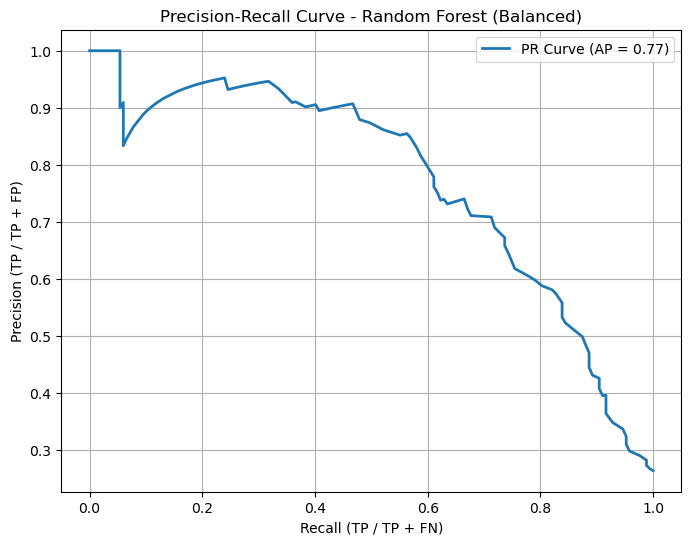

In [109]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Step 1: הסתברויות למחלקה 1 (כמו שכבר חישבת)
y_scores = rf_balanced.predict_proba(X_test)[:, 1]

# Step 2: חישוב Precision ו-Recall בכל סף אפשרי
precision, recall, thresholds = precision_recall_curve(Y_test, y_scores)

# Step 3: חישוב השטח תחת עקומת PR (Average Precision Score)
ap_score = average_precision_score(Y_test, y_scores)

# Step 4: ציור הגרף
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})', linewidth=2)
plt.xlabel('Recall (TP / TP + FN)')
plt.ylabel('Precision (TP / TP + FP)')
plt.title('Precision-Recall Curve - Random Forest (Balanced)')
plt.grid(True)
plt.legend()
plt.show()


### Feature importances

In [107]:
# Feature importances
feature_importances = pd.Series(rf_balanced.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False)

RAMZOR                         0.103463
veteran_driver_years           0.102110
hour_sin                       0.092695
hour_cos                       0.090006
KVUZA_GIL                      0.074869
HODESH_TEUNA_sin               0.072983
YOM_BASHAVUA_sin               0.070147
ROHAV                          0.069221
HODESH_TEUNA_cos               0.068518
YOM_BASHAVUA_cos               0.048496
MEHIRUT_MUTERET                0.045834
SEX                            0.018307
is_night                       0.018259
_TwoWay_Unseparated            0.017087
_MultiLaneOneWay               0.016277
vehicle_0                      0.013639
_SingleLaneOneWay              0.012670
vehicle_1                      0.011071
vehicle_2                      0.009834
SUG_YOM_Weekday                0.007542
is_slippery_road               0.007286
is_signage_problem             0.006735
is_not_clear_weather           0.006627
SUG_YOM_IntermediateHoliday    0.004740
_TwoWay_Separated              0.003706


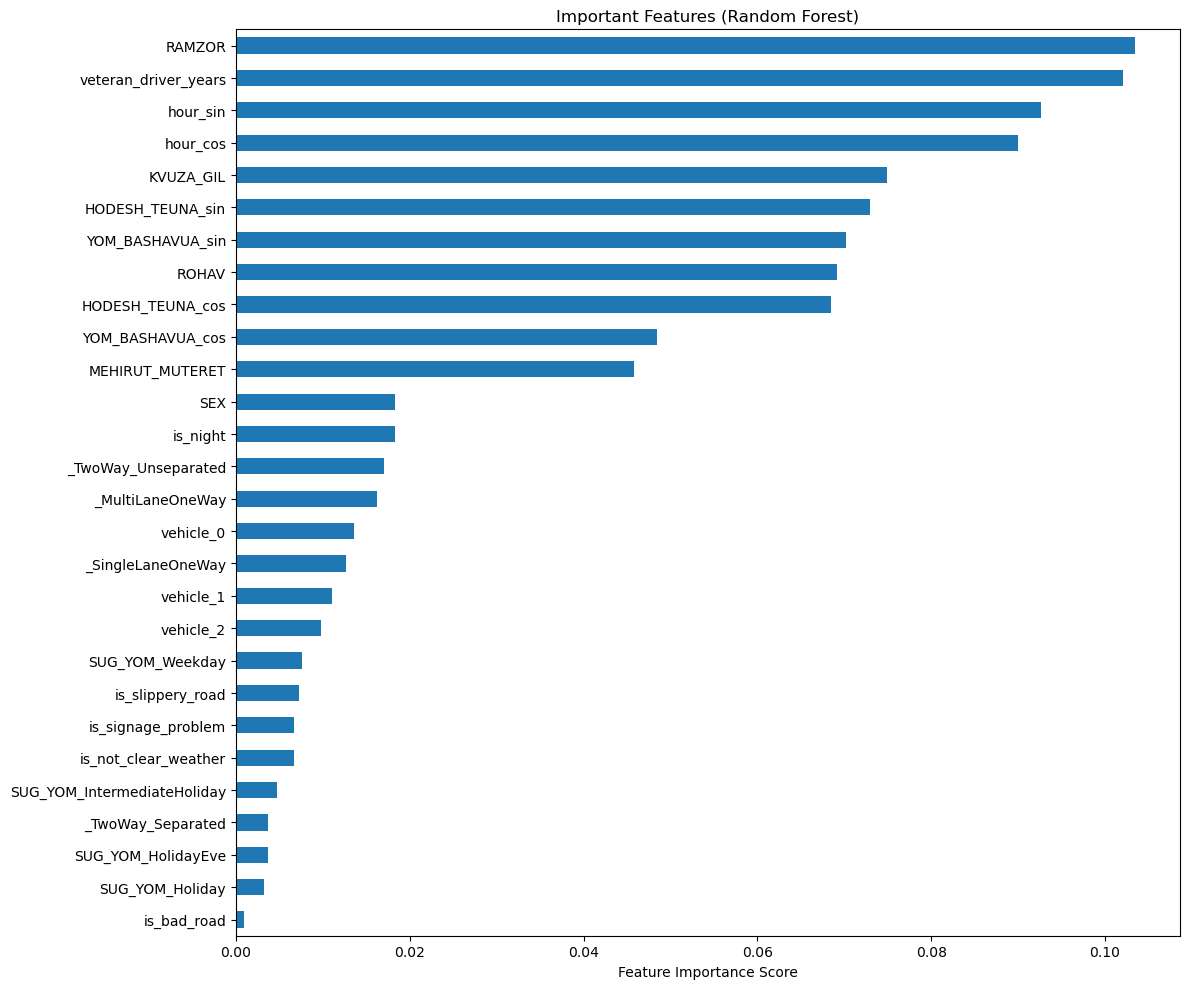

In [108]:
import matplotlib.pyplot as plt

# Sort and take top 10
top_features = feature_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 10))
top_features.plot(kind='barh')
plt.title("Important Features (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()


## A.6 - Experimentation

# B - Define the Prediction Function - Insights and Analysis
<img src="images/visual.jpg" alt="tools Image">